In the notebook **Overlap_5s_GW150914**, we have found a way that enables to add a signal with a given time-shift to the pre-existing one for the GW150914 event. This one is chosen because it has a high SNR and enables to avoid the glitch present in the usual example used. In that notebook, the addition of the signal 5 s after the real one was done and a method, based on matched filtering as well as fitting enabled to extract first the injection and then the other signal.

Here, we try to do the same method but for different gaps between the event. The goal is to see when it won't be possible any more to find the two events, as well as to see how the matched filtering respond as the signals start to overlap.

The first time gap that is done here is 2s

## For a 2s gap

In [1]:
# Beautiful plots
%matplotlib inline 

#first we need to set bigger characters for the titles, labels and thicks.
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [2]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import matched_filter, highpass
import numpy as np
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.filter import sigma


In [1]:
#prepare the signal for injection
merger = Merger("GW150914")
strain = merger.strain('H1')
strain = highpass(strain, 15)
strain = strain.crop(2,2)

strainF = strain.to_frequencyseries()

NameError: name 'Merger' is not defined

In [4]:
#best fit template of the event, as found in the previous notebook

#freq
hp_f, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = 40.3, 
                         mass2 = 32.3, distance = 440, f_lower = 20., 
                                delta_f = strainF.delta_f)
hp_f.resize(len(strainF))
hp_f.start_time = strainF.start_time

#time
hp_t, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 40.3, 
                         mass2 = 32.3, distance = 440, f_lower = 20., 
                         delta_t = strain.delta_t)
hp_t.resize(len(strain))
hp_t.start_time = strain.start_time

In [5]:
#add the injection at 2 seconds

time_shifts = np.arange(5,20, 0.01)

model_inj = None
max_amp_inj, time_inj, time_diff = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", 
                               mass1 = 40.3, mass2 = 32.3, 
                              distance = 440, f_lower =  20., 
                              delta_t = strain.delta_t)
    hpInj.resize(len(strain))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strain.start_time
    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_ev = hpInj.sample_times[ind]
    time_diff = time_ev - merger.time
    if (abs(time_diff - 2) < 0.01):
        model_inj = hpInj
        max_amp_inj, time_inj, time_dif_inj = max_amp, time_ev, time_diff

In [6]:
print(model_inj)
print(time_dif_inj)

[-1.54175329e-28  1.54128623e-28 -1.54081915e-28 ...  1.54315453e-28
 -1.54268745e-28  1.54222038e-28]
2.0084471702575684


In [7]:
#vizualisation of the two signal
plt.plot(hp_t.sample_times, hp_t, label = 'GW150914 model')
plt.plot(model_inj.sample_times, model_inj, label = 'injected signal')
plt.grid()
plt.legend()
plt.xlabel("GPS Time (s)")
plt.ylabel("Strain")
plt.title("Comparison of the two models of waveform present in the signal", pad = 20)

Text(0.5,1,'Comparison of the two models of waveform present in the signal')

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [8]:
#infos about the injection
print("Max amplitude: ", max_amp_inj)
print("time of the merger for the injection: ", time_inj)
print("Time gap between merger and injection: ", time_dif_inj)

('Max amplitude: ', 1.8173232814307215e-21)
('time of the merger for the injection: ', 1126259464.4084473)
('Time gap between merger and injection: ', 2.0084471702575684)


In [9]:
#add injection to the strain in time and freq domain
sig = strain + model_inj

sigF = sig.to_frequencyseries()

p = sig.psd(2)
p = interpolate(p, sig.delta_f)
psd = inverse_spectrum_truncation(p, 2*sig.sample_rate,
                                 low_frequency_cutoff = 20.)

/home/justin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0,0.5,'Normalized amplitude')

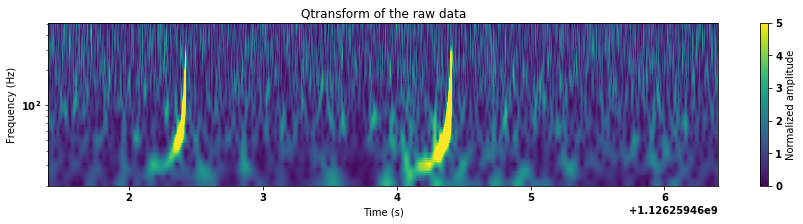

In [10]:
#qtransfo to see what the signal looks like

zoom = sig.whiten(4,4).time_slice(merger.time - 1, merger.time + 4)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange = (20,512),
                             qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 1, merger.time + 4)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

The signals are still relatively well separated. So, I expect that the setup found for the previous case works well enought in this situation and sould be able to work

In [11]:
#we do the loop over the mass to see which gives the best result

mass1 = np.arange(32.5, 42.1, 0.1)
mass2 = np.arange(29.7, 34.1, 0.1)

hmax = None
maxsnr, m1max, m2max, tmax = 0, 0, 0, 0

snrs = [[] for i in range(len(mass1))]
max_snrs = [[] for i in range(len(mass1))]
times_max = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass 1: %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        
        #generate the waveform 
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20.,
                               delta_f = sigF.delta_f)
        hp.resize(len(sigF))
        
        snr = matched_filter(hp, sigF, psd = psd, 
                             low_frequency_cutoff = 20.)
        #we look only at the time slive that encapsulate the two events
        snr = snr.time_slice(merger.time - 2, merger.time + 5)
        snrs[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs[i].append(snrp)
        time = snr.sample_times[idx]
        times_max[i].append(time)
        
        #kep track of the max snr
        if snrp > maxsnr:
            tmax, hmax, m1max, m2max, maxsnr = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1max, m2max, tmax, maxsnr))
print(" time of injection: %.7f" %time_inj)
print("Time of GW150914: %.7f" %merger.time)


Mass 1: 1/97
Done
Mass 1: 2/97
Done
Mass 1: 3/97
Done
Mass 1: 4/97
Done
Mass 1: 5/97
Done
Mass 1: 6/97
Done
Mass 1: 7/97
Done
Mass 1: 8/97
Done
Mass 1: 9/97
Done
Mass 1: 10/97
Done
Mass 1: 11/97
Done
Mass 1: 12/97
Done
Mass 1: 13/97
Done
Mass 1: 14/97
Done
Mass 1: 15/97
Done
Mass 1: 16/97
Done
Mass 1: 17/97
Done
Mass 1: 18/97
Done
Mass 1: 19/97
Done
Mass 1: 20/97
Done
Mass 1: 21/97
Done
Mass 1: 22/97
Done
Mass 1: 23/97
Done
Mass 1: 24/97
Done
Mass 1: 25/97
Done
Mass 1: 26/97
Done
Mass 1: 27/97
Done
Mass 1: 28/97
Done
Mass 1: 29/97
Done
Mass 1: 30/97
Done
Mass 1: 31/97
Done
Mass 1: 32/97
Done
Mass 1: 33/97
Done
Mass 1: 34/97
Done
Mass 1: 35/97
Done
Mass 1: 36/97
Done
Mass 1: 37/97
Done
Mass 1: 38/97
Done
Mass 1: 39/97
Done
Mass 1: 40/97
Done
Mass 1: 41/97
Done
Mass 1: 42/97
Done
Mass 1: 43/97
Done
Mass 1: 44/97
Done
Mass 1: 45/97
Done
Mass 1: 46/97
Done
Mass 1: 47/97
Done
Mass 1: 48/97
Done
Mass 1: 49/97
Done
Mass 1: 50/97
Done
Mass 1: 51/97
Done
Mass 1: 52/97
Done
Mass 1: 53/97
Done
Ma

The parameters that are found are not exactly the ones provided. We will try to do directly the subtraction out of the data. If this does  not work, we will apply the best fit situation

Text(0,0.5,'Normalized amplitude')

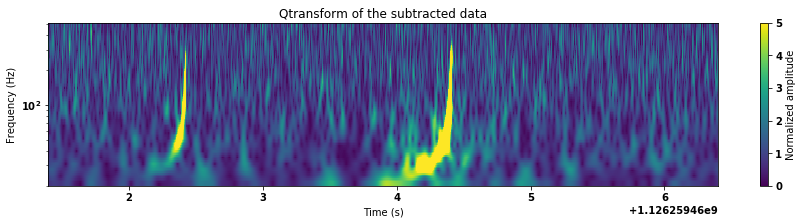

In [12]:
from pycbc.filter import sigma

dt = tmax - sigF.start_time
inj = hmax.cyclic_time_shift(dt)

#scaling of the template
inj /= sigma(hmax, psd = psd, low_frequency_cutoff = 20.)
inj *= maxsnr

#subtraction
subF = sigF - inj

#whiten
subT_w = (subF/psd**0.5).to_timeseries()
zoom = subT_w.time_slice(merger.time - 1, merger.time + 4)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 1, merger.time + 4)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

As was the case in the previous notebook, the direct subtraction does not work. So, we will use a best fit routine in order to adjust the paramters before doing the subtraction.

In [13]:
f_low = 20.
f_upper = 1024.

#starting model
hp_st, hf_st = get_td_waveform(approximant = "SEOBNRv4_opt",
                              mass1 = m1max, mass2 = m2max,
                              distance = 440, delta_t = sig.delta_t,
                              f_lower = f_low)
plt.plot(hp_st.sample_times, hp_st)
plt.grid()
plt.title("Starting waveform")
plt.xlabel("Time (s)")
plt.ylabel("Strain")

Text(0,0.5,'Strain')

Text(0.5,1,'Whitened data of GW150914 with the signal injected at 2 s')

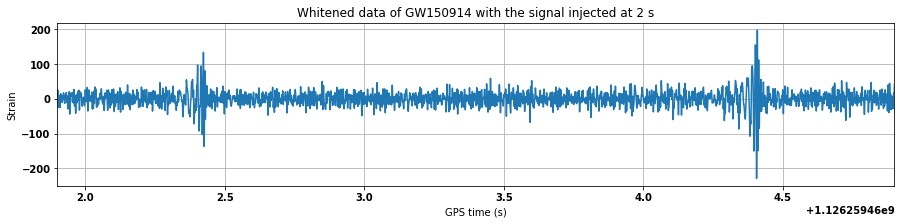

In [14]:
#whitening of the data

white_sig = (sigF/psd**0.5).to_timeseries()
white_sig = white_sig.highpass_fir(30., 512).lowpass_fir(300., 512)
white_sig = white_sig.time_slice(merger.time - 5, merger.time + 10)

plt.figure(figsize = [15,3])
plt.plot(white_sig.sample_times, white_sig)
plt.xlim(merger.time - 0.5, merger.time + 2.5)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.grid()
plt.title("Whitened data of GW150914 with the signal injected at 2 s")


In [15]:
def gen_template(theta, delta_t = sig.delta_t, 
                 duration = sig.duration, start_time = sig.start_time,
                 f_lower = f_low):
    
    #unpack values used to adapt the template
    m1, m2, dist, time = theta
    
    #make the templayte with the values provided and adjust it to data
    hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1,
                            mass2 = m2, distance = dist, 
                             delta_t = delta_t, f_lower = f_low)
    
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - sig.start_time)
    hp.start_time = sig.start_time
    
    return hp

In [16]:
from pycbc.filter import get_cutoff_indices as get_ind
def loglikelihood(theta, df = sigF, f_lower = f_low, f_upper = f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t = df.delta_t, 
                            f_lower = f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = get_ind(f_lower, f_upper, df.delta_f,
                                          (N-1)*2)
    
    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj() * hf[kmin:kmax]).real()/psd[kmin:kmax])
    dh = sum (4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
    
    logl = -0.5*(hh - 2.0*dh)
    
    return logl

In [17]:
def whiten_trim_template(template, psd = psd):
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd**0.5).to_timeseries()
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(30,512)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 10)
    
    return white_temp

def plot_white_strain(strain, template, zoom):
    white_data = (sigF/psd**0.5).to_timeseries()
    
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd **0.5).to_timeseries()
    
    white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data = white_data.time_slice(merger.time - 5, merger.time + 10)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 10)
    
    plt.figure(figsize = [15 , 5])
    plt.plot(white_data.sample_times, white_data, label = 'data')
    plt.plot(white_temp.sample_times, white_temp, label = 'template')
    plt.legend()
    plt.grid()
    plt.title("Superposition data and template")
    plt.ylabel("Strain")
    plt.xlabel("GPS time (s)")
    
    if zoom is True:
        plt.xlim(merger.time - 0.5, merger.time + 2.5)
    if zoom is False:
        plt.xlim(merger.time - 2, merger.time + 5)
        

-1020.0088573815626


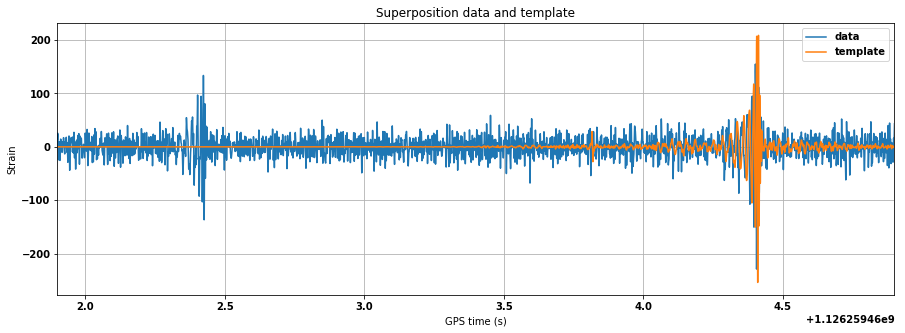

In [18]:
#initialisation of the values to those found with the matched filtering

theta0 = [m1max, m2max, 440, tmax]

temp0 = gen_template(theta0)
plot_white_strain(sig, temp0, True)

print(loglikelihood(theta0))

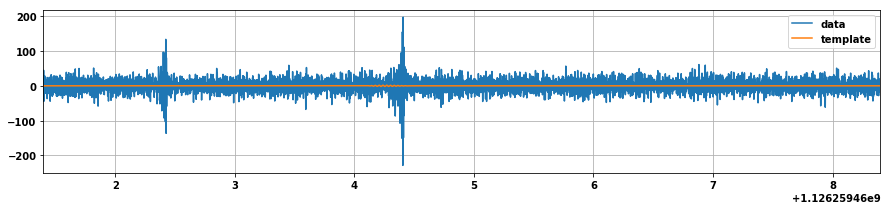

Steps 	 log(likelihood)
7 	 463.409


In [19]:
#best fit to adapt the found parameters to the signal
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize = [15, 3])
Neval = 1

white_temp = whiten_trim_template(gen_template(theta0))

plt.plot(white_sig.sample_times, white_sig, label = 'data')
line, = plt.plot(white_temp.sample_times, white_temp, label = 'template')

plt.xlim(merger.time - 1, merger.time + 6)
plt.grid()
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    temp = gen_template(thetai)
    white_temp = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_temp)
    
    clear_output(wait = True)
    display(fig)
    print("Steps \t log(likelihood)")
    print("%i \t %.3f" %(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta : -loglikelihood(theta), theta0, 
              callback = callback, method = 'powell')
plt.close()

[4.39113079e+01 3.14971597e+01 5.07311411e+02 1.12625946e+09]


Text(0.5,1,'Whitened signal and best fit template for 2s')

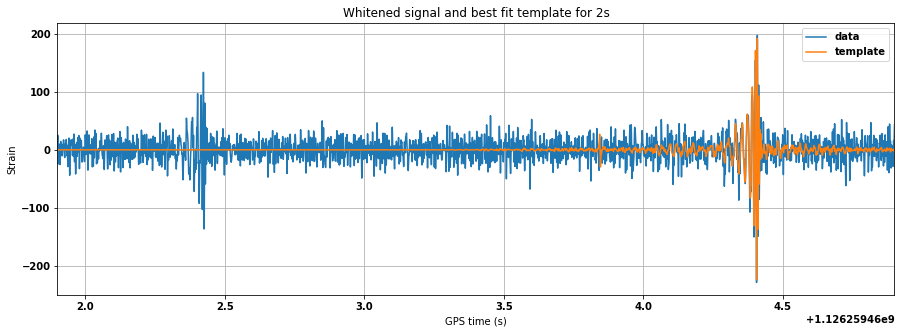

In [20]:
params = res.x
print(params)
best_fit_temp = gen_template(params)
plot_white_strain(sig, best_fit_temp, True)
plt.title("Whitened signal and best fit template for 2s")

(1126259464.2084472, 1126259464.6084473)

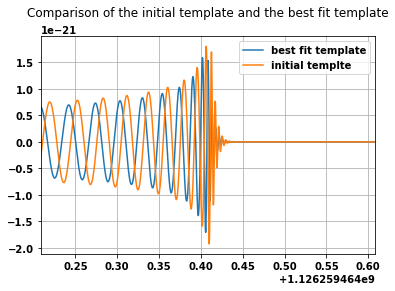

In [21]:
#comparison of the best fit template and the original template
plt.plot(best_fit_temp.sample_times, best_fit_temp, label = 'best fit template')
plt.plot(temp0.sample_times, temp0, label = 'initial templte')
plt.title("Comparison of the initial template and the best fit template", 
         pad = 20)
plt.grid()
plt.legend(loc='best')
plt.xlim(merger.time + time_dif_inj - 0.2, merger.time + time_dif_inj + 0.2)

Text(0,0.5,'Normalized amplitude')

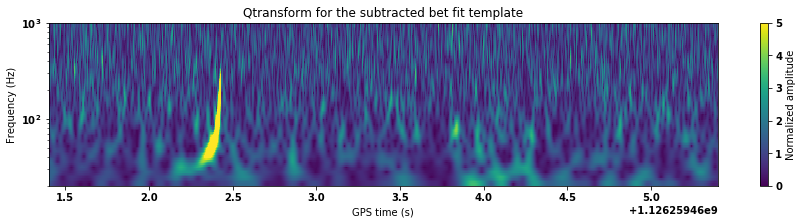

In [22]:
#try to subtract the best fit template to see if it works

subtracted = sig - best_fit_temp

t, f, p = subtracted.whiten(4,4).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted bet fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 1, merger.time + 3)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
#plt.axvline(merger.time, color = 'red')
#plt.axvline(merger.time + time_dif_inj, alpha = 0.7, color = 'orange')

The subtraction can be done with this technique. So, we have still the possibility to detect one event and then subtract it out of the data. Now, to check, we see if we still have the possibility to detect and subtract the other data

Text(0.5,1,'PSD of the subtracted data')

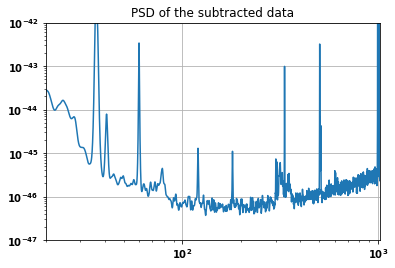

In [23]:
#psd of the subtracted data
p = subtracted.psd(2)
p = interpolate(p, subtracted.delta_f)
psd_s = inverse_spectrum_truncation(p, 2*subtracted.sample_rate, 
                                  low_frequency_cutoff = 15.,
                                  trunc_method = 'hann')

#plot it
plt.loglog(psd_s.sample_frequencies, psd_s)
plt.grid()
plt.xlim(20,1024)
plt.ylim(1e-47, 1e-42)
plt.title("PSD of the subtracted data")

In [24]:
#subtracted signal in the frequency domain
subF = subtracted.to_frequencyseries()

In [25]:
#matched filtering for the event

mass1 = np.arange(32.5, 40.4, 0.1)
mass2 = np.arange(29.1, 32.4, 0.1)

hmaxS = None
maxsnrS, m1maxS, m2maxS, tmaxS = 0, 0, 0, 0

snrsS = [[] for i in range(len(mass1))]
max_snrsS = [[] for i in range(len(mass1))]
time_maxS = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass 1: %i/%i" %(i+1,len(mass1)))
    for m2 in mass2:
        #template generation
        hp, _ = get_fd_waveform(approximant = 'IMRPhenomD', mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20.,
                               delta_f = subF.delta_f)
        hp.resize(len(subF))
        
        #matched filtering
        snr = matched_filter(hp, subF, psd = psd_s, 
                             low_frequency_cutoff = 20.)
        snr = snr.time_slice(merger.time - 10, merger.time + 10)
        snrsS[i].append(snr)
        ind = abs(snr).numpy().argmax()
        snrp = abs(snr[ind])
        max_snrsS[i].append(snrp)
        time = snr.sample_times[ind]
        time_maxS[i].append(time)
        
        #keep track of max snr
        
        if snrp > maxsnrS:
            tmaxS, hmaxS, m1maxS, m2maxS, maxsnrS = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.2f and m2 = %.2f at time %.7f with a value of %.7f" %(m1maxS, m2maxS, tmaxS, maxsnrS))

Mass 1: 1/79
Done
Mass 1: 2/79
Done
Mass 1: 3/79
Done
Mass 1: 4/79
Done
Mass 1: 5/79
Done
Mass 1: 6/79
Done
Mass 1: 7/79
Done
Mass 1: 8/79
Done
Mass 1: 9/79
Done
Mass 1: 10/79
Done
Mass 1: 11/79
Done
Mass 1: 12/79
Done
Mass 1: 13/79
Done
Mass 1: 14/79
Done
Mass 1: 15/79
Done
Mass 1: 16/79
Done
Mass 1: 17/79
Done
Mass 1: 18/79
Done
Mass 1: 19/79
Done
Mass 1: 20/79
Done
Mass 1: 21/79
Done
Mass 1: 22/79
Done
Mass 1: 23/79
Done
Mass 1: 24/79
Done
Mass 1: 25/79
Done
Mass 1: 26/79
Done
Mass 1: 27/79
Done
Mass 1: 28/79
Done
Mass 1: 29/79
Done
Mass 1: 30/79
Done
Mass 1: 31/79
Done
Mass 1: 32/79
Done
Mass 1: 33/79
Done
Mass 1: 34/79
Done
Mass 1: 35/79
Done
Mass 1: 36/79
Done
Mass 1: 37/79
Done
Mass 1: 38/79
Done
Mass 1: 39/79
Done
Mass 1: 40/79
Done
Mass 1: 41/79
Done
Mass 1: 42/79
Done
Mass 1: 43/79
Done
Mass 1: 44/79
Done
Mass 1: 45/79
Done
Mass 1: 46/79
Done
Mass 1: 47/79
Done
Mass 1: 48/79
Done
Mass 1: 49/79
Done
Mass 1: 50/79
Done
Mass 1: 51/79
Done
Mass 1: 52/79
Done
Mass 1: 53/79
Done
Ma

In [26]:
print(merger.time)

1126259462.4


Text(0,0.5,'Normalized amplitude')

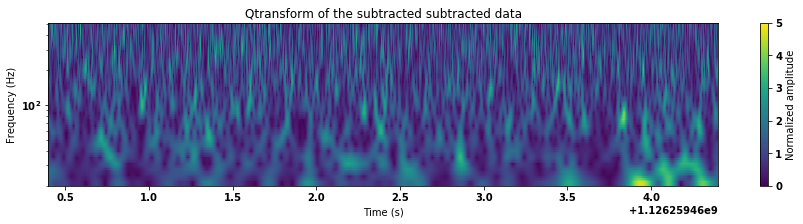

In [27]:
#do the subtraction

#see if the data can directly be subtracted out of the data,
#else fitting


dt = tmaxS - subF.start_time
inj = hmaxS.cyclic_time_shift(dt)

#scale tempplate

inj /= sigma(hmaxS, psd = psd_s, low_frequency_cutoff = 20.)
inj *= maxsnrS

subsubF = subF - inj

#whiten 

subsub_white = (subsubF/psd_s**0.5).to_timeseries()
zoom = subsub_white.time_slice(merger.time -2, merger.time + 2)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))

plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 2, merger.time + 2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

The subtraction of the data and analysis of the event is still possible in this case. So, we can decrease a bit more the size of the gap and see what happens

## For 1 second interval

In [4]:
# reimport the data to work from scratch again
merger = Merger("GW150914")
strain = merger.strain("H1")
strain = highpass(strain, 15.)
strain = strain.crop(2,2)

strainF = strain.to_frequencyseries()

In [5]:
p1 = strain.psd(2)
p1 = interpolate(p1, strainF.delta_f)
psd1 = inverse_spectrum_truncation(p1, 2*strain.sample_rate, 
                                  low_frequency_cutoff = 15.)

In [6]:
#best fit model based on the result from the previous notebook

#freq
hp_f, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = 40.3, 
                         mass2 = 32.3, distance = 440, f_lower = 20., 
                                delta_f = strainF.delta_f)
hp_f.resize(len(strainF))
hp_f.start_time = strainF.start_time

#time
hp_t, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 40.3, 
                         mass2 = 32.3, distance = 440, f_lower = 20., 
                         delta_t = strain.delta_t)
hp_t.resize(len(strain))
hp_t.start_time = strain.start_time

In [7]:
#building the injected signal at 2 sec

time_shifts = np.arange(5, 20, 0.01)

model_1s = None
max_amp_1s, time_inj_1s, time_dif_1s = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt",
                              mass1 = 40.3, mass2 = 32.3, distance = 440,
                              f_lower = 20., delta_t = strain.delta_t)
    hpInj.resize(len(strain))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strain.start_time
    
    ind = hpInj.numpy().argmax()
    maxAmp = hpInj[ind]
    timeEv = hpInj.sample_times[ind]
    timeDif = timeEv - merger.time
    if (abs(timeDif - 1) < 0.01):
        model_1s = hpInj
        max_amp_1s, time_inj_1s, time_dif_1s = maxAmp, timeEv, timeDif

In [8]:
print(model_1s)
print(time_dif_1s)

[ 3.59912414e-29 -3.60375868e-29  3.60839274e-29 ... -3.58522176e-29
  3.58985539e-29 -3.59449026e-29]
1.0084471702575684


In [10]:
#info about injection
print("Max amp: ", max_amp_1s)
print("Time of the merger for injection: ", time_inj_1s)
print("Time gap between merger and injection: ", time_dif_1s)

('Max amp: ', 1.8173232814264047e-21)
('Time of the merger for injection: ', 1126259463.4084473)
('Time gap between merger and injection: ', 1.0084471702575684)


In [11]:
#add injection to strain
sig1 = strain + model_1s
sig1F = sig1.to_frequencyseries()

pp = sig1.psd(2)
pp = interpolate(pp, sig1.delta_f)
psd1 = inverse_spectrum_truncation(pp, 2*sig1.sample_rate, 
                                    low_frequency_cutoff = 20.) 

In [12]:
#qtransform to see how the events are the one wrt the other

zoom = sig1.whiten(4,4).time_slice(merger.time - 1, merger.time +2)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange = (20,512),
                             qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 1, merger.time + 2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

/home/justin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0,0.5,'Normalized amplitude')

In [15]:
mass1 = np.arange(32.5, 42.1, 0.1)
mass2 = np.arange(29.1, 34.1, 0.1)

hmax1 = None
maxsnr1, m1max1, m2max1, tmax1 = 0, 0, 0, 0

snrs = [[] for i in range(len(mass1))]
max_snrs1 = [[] for i in range(len(mass1))]
time_max1 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass 1: %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #genreate the waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20.,
                               delta_f = sig1F.delta_f)
        hp.resize(len(sig1F))
        
        snr = matched_filter(hp, sig1F, psd = psd1, 
                             low_frequency_cutoff = 20.)
        snr = snr.time_slice(merger.time - 1 , merger.time + 5)
        snrs[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs1[i].append(snrp)
        time = snr.sample_times[idx]
        time_max1[i].append(time)
        
        if snrp > maxsnr1:
            tmax1, hmax1, m1max1, m2max1, maxsnr1 = time, hp, m1, m2, snrp
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.2f and m2 = %.2f at time %.7f with a SNR value of %.7f" %(m1max1, m2max1, tmax1, maxsnr1))
print(merger.time)
print(time_inj_1s)

Mass 1: 1/97
Done
Mass 1: 2/97
Done
Mass 1: 3/97
Done
Mass 1: 4/97
Done
Mass 1: 5/97
Done
Mass 1: 6/97
Done
Mass 1: 7/97
Done
Mass 1: 8/97
Done
Mass 1: 9/97
Done
Mass 1: 10/97
Done
Mass 1: 11/97
Done
Mass 1: 12/97
Done
Mass 1: 13/97
Done
Mass 1: 14/97
Done
Mass 1: 15/97
Done
Mass 1: 16/97
Done
Mass 1: 17/97
Done
Mass 1: 18/97
Done
Mass 1: 19/97
Done
Mass 1: 20/97
Done
Mass 1: 21/97
Done
Mass 1: 22/97
Done
Mass 1: 23/97
Done
Mass 1: 24/97
Done
Mass 1: 25/97
Done
Mass 1: 26/97
Done
Mass 1: 27/97
Done
Mass 1: 28/97
Done
Mass 1: 29/97
Done
Mass 1: 30/97
Done
Mass 1: 31/97
Done
Mass 1: 32/97
Done
Mass 1: 33/97
Done
Mass 1: 34/97
Done
Mass 1: 35/97
Done
Mass 1: 36/97
Done
Mass 1: 37/97
Done
Mass 1: 38/97
Done
Mass 1: 39/97
Done
Mass 1: 40/97
Done
Mass 1: 41/97
Done
Mass 1: 42/97
Done
Mass 1: 43/97
Done
Mass 1: 44/97
Done
Mass 1: 45/97
Done
Mass 1: 46/97
Done
Mass 1: 47/97
Done
Mass 1: 48/97
Done
Mass 1: 49/97
Done
Mass 1: 50/97
Done
Mass 1: 51/97
Done
Mass 1: 52/97
Done
Mass 1: 53/97
Done
Ma

In [24]:
from pycbc.filter import sigma
#check if the direct subtraction still does not work

dt = tmax1 - sig1F.start_time
inj1 = hmax1.cyclic_time_shift(dt)

#scale the template
inj1 /= sigma(hmax1, psd = psd1, low_frequency_cutoff = 20.)
inj1 *= maxsnr1

#subtraction in the frequency domain
subF1 = sig1F - inj1

#whiten the data
subT1_w = (subF1/psd1**0.5).to_timeseries()
zoom = subT1_w.time_slice(merger.time - 1, merger.time + 2)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 1, merger.time + 2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

Text(0,0.5,'Normalized amplitude')

The subtraction is not well done in this case. So, we need to adjust the template as has been done previously

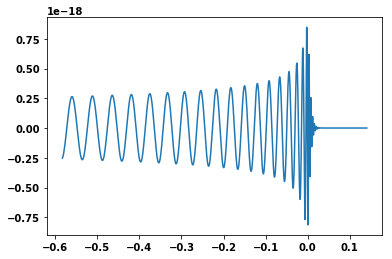

In [26]:
f_low = 20.
f_upper = 1024.

#starting model

hp_st1, _ = get_td_waveform(approximant = "SEOBNRv4_opt", 
                            mass1 = 42.1, mass2 = 31.7, 
                            delta_t = sig1.delta_t, f_lower = f_low)
plt.plot(hp_st1.sample_times, hp_st1)

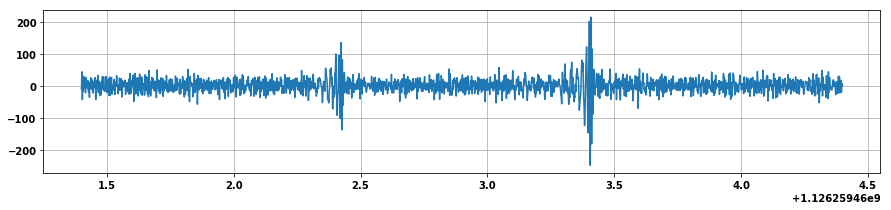

In [29]:
#whiten the data
Wsig1 = (sig1F/psd1 ** 0.5).to_timeseries()
Wsig1 = Wsig1.highpass_fir(30.,512).lowpass_fir(300.,512)
Wsig1 = Wsig1.time_slice(merger.time - 1, merger.time + 2)

plt.figure(figsize=[15,3])
plt.plot(Wsig1.sample_times, Wsig1)
plt.grid()

In [31]:
def gen_template(theta, delta_t = sig1.delta_t, 
                 duration = sig1.duration, start_time = sig1.start_time,
                 f_lower = f_low):
    
    #unpack values used to adapt the template
    m1, m2, dist, time = theta
    
    #make the templayte with the values provided and adjust it to data
    hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1,
                            mass2 = m2, distance = dist, 
                             delta_t = delta_t, f_lower = f_low)
    
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - sig1.start_time)
    hp.start_time = sig1.start_time
    
    return hp

In [42]:
from pycbc.filter import get_cutoff_indices as get_ind

def loglikelihood(theta, df = sig1F, f_lower = f_low, f_upper = f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t = df.delta_t, 
                            f_lower = f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = get_ind(f_lower, f_upper, df.delta_f,
                                          (N-1)*2)
    
    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj() * hf[kmin:kmax]).real()/psd1[kmin:kmax])
    dh = sum (4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd1[kmin:kmax])
    
    logl = -0.5*(hh - 2.0*dh)
    
    return logl

In [56]:
def whiten_trim_template(template, psd = psd1):
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd**0.5).to_timeseries()
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 10)
    
    return white_temp

def plot_white_strain(strain, template, zoom):
    white_data = (sig1F/psd1**0.5).to_timeseries()
    
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd1 **0.5).to_timeseries()
    
    white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data = white_data.time_slice(merger.time - 5, merger.time + 10)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 10)
    
    plt.figure(figsize = [15 , 3])
    plt.plot(white_data.sample_times, white_data, label = 'data')
    plt.plot(white_temp.sample_times, white_temp, label = 'template')
    plt.legend()
    plt.grid()
    plt.title("Superposition data and template")
    plt.ylabel("Strain")
    plt.xlabel("GPS time (s)")
    
    if zoom is True:
        plt.xlim(merger.time - 0.5, merger.time + 2)
    if zoom is False:
        plt.xlim(merger.time - 1, merger.time + 2)
        

-578.9137974345864


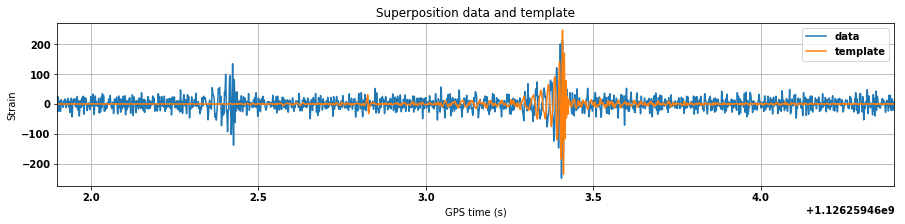

In [47]:
#starting template

theta0 = [m1max1, m2max1, 440, tmax1]

startTemp1 = gen_template(theta0)
plot_white_strain(sig1, startTemp1, True)

print(loglikelihood(theta0))

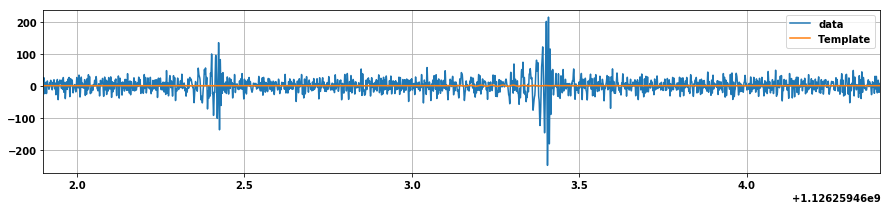

Steps 	 log(likelihood)
7 	 582.917


In [50]:
#best fit to adapt
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize = [15, 3])
Neval = 1

Wtemp = whiten_trim_template(gen_template(theta0))

plt.plot(Wsig1.sample_times, Wsig1, label = 'data')
line, = plt.plot(Wtemp.sample_times, Wtemp, label = 'Template')

plt.xlim(merger.time - 0.5, merger.time + 2)
plt.grid()
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    temp = gen_template(thetai)
    Wtemp = whiten_trim_template(gen_template(thetai))
    line.set_ydata(Wtemp)
    
    clear_output(wait = True)
    display(fig)
    print("Steps \t log(likelihood)")
    print("%i \t %.3f" %(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta : -loglikelihood(theta), theta0, 
              callback = callback, method = 'powell')

plt.close()

[4.31705377e+01 3.21154206e+01 4.55255505e+02 1.12625946e+09]


Text(0.5,1,'Whitened signal with the best fit template')

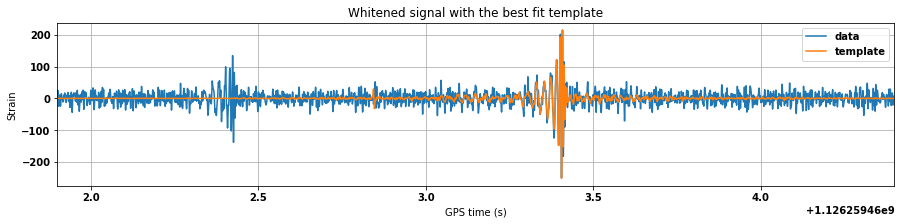

In [57]:
param1 = res.x
print(param1)
best_fit_temp = gen_template(param1)
plot_white_strain(sig1, best_fit_temp, True)
plt.title("Whitened signal with the best fit template")

Text(0,0.5,'Normalized amplitude')

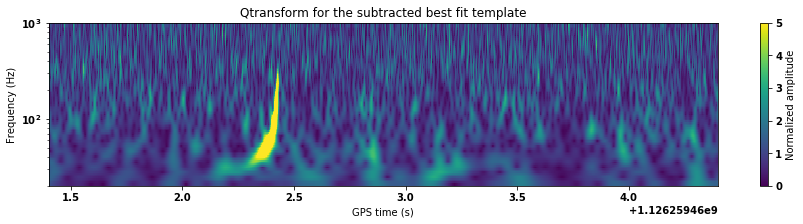

In [59]:
sub11 = sig1 - best_fit_template

t, f, p = sub11.whiten(4,4).qtransform(.001, logfsteps = 100, 
                                       frange=(20, 1000),
                         qrange = (8,8))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted best fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 1, merger.time + 2)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

For a 1 second gap, we see that the subtraction is still well possible to do. Still, we chack that the subtraction afterward of the remaining signal is possible 

In [60]:
#psd of the subtracted data

ps = sub11.psd(2)
ps = interpolate(ps, sub11.delta_f)
psdS1 = inverse_spectrum_truncation(ps, 2*sub11.sample_rate, 
                                   low_frequency_cutoff = 15., 
                                   trunc_method = ' hann ')

In [61]:
sub11F = sub11.to_frequencyseries()

In [65]:
#mtched filtering in this case

mass1 = np.arange(32.5, 40.4, 0.1)
mass2 = np.arange(29.1, 32.4, 0.1)

hmaxS1 = None
maxsnrS1, m1maxS1, m2maxS1, tmaxS1 = 0, 0, 0, 0

snrsS1 = [[] for i in range(len(mass1))]
max_snrsS1 = [[] for i in range(len(mass1))]
time_maxS1 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass 1: %i/%i" %(i+1,len(mass1)))
    for m2 in mass2:
        #template generation
        hp, _ = get_fd_waveform(approximant = 'IMRPhenomD', 
                                mass1 = m1,
                               mass2 = m2, distance = 440, 
                                f_lower = 20.,
                               delta_f = sub11F.delta_f)
        hp.resize(len(sub11F))
        
        #matched filtering
        snr = matched_filter(hp, sub11F, psd = psdS1, 
                             low_frequency_cutoff = 20.)
        snr = snr.time_slice(merger.time - 5, merger.time + 10)
        snrsS1[i].append(snr)
        ind = abs(snr).numpy().argmax()
        snrp = abs(snr[ind])
        max_snrsS1[i].append(snrp)
        time = snr.sample_times[ind]
        time_maxS1[i].append(time)
        
        #keep track of max snr
        
        if snrp > maxsnrS1:
            tmaxS1, hmaxS1, m1maxS1, m2maxS1, maxsnrS1 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.2f and m2 = %.2f at time %.7f with a value of %.7f" %(m1maxS1, m2maxS1, tmaxS1, maxsnrS1))

Mass 1: 1/79
Done
Mass 1: 2/79
Done
Mass 1: 3/79
Done
Mass 1: 4/79
Done
Mass 1: 5/79
Done
Mass 1: 6/79
Done
Mass 1: 7/79
Done
Mass 1: 8/79
Done
Mass 1: 9/79
Done
Mass 1: 10/79
Done
Mass 1: 11/79
Done
Mass 1: 12/79
Done
Mass 1: 13/79
Done
Mass 1: 14/79
Done
Mass 1: 15/79
Done
Mass 1: 16/79
Done
Mass 1: 17/79
Done
Mass 1: 18/79
Done
Mass 1: 19/79
Done
Mass 1: 20/79
Done
Mass 1: 21/79
Done
Mass 1: 22/79
Done
Mass 1: 23/79
Done
Mass 1: 24/79
Done
Mass 1: 25/79
Done
Mass 1: 26/79
Done
Mass 1: 27/79
Done
Mass 1: 28/79
Done
Mass 1: 29/79
Done
Mass 1: 30/79
Done
Mass 1: 31/79
Done
Mass 1: 32/79
Done
Mass 1: 33/79
Done
Mass 1: 34/79
Done
Mass 1: 35/79
Done
Mass 1: 36/79
Done
Mass 1: 37/79
Done
Mass 1: 38/79
Done
Mass 1: 39/79
Done
Mass 1: 40/79
Done
Mass 1: 41/79
Done
Mass 1: 42/79
Done
Mass 1: 43/79
Done
Mass 1: 44/79
Done
Mass 1: 45/79
Done
Mass 1: 46/79
Done
Mass 1: 47/79
Done
Mass 1: 48/79
Done
Mass 1: 49/79
Done
Mass 1: 50/79
Done
Mass 1: 51/79
Done
Mass 1: 52/79
Done
Mass 1: 53/79
Done
Ma

In [66]:
print(merger.time)

1126259462.4


Text(0,0.5,'Normalized amplitude')

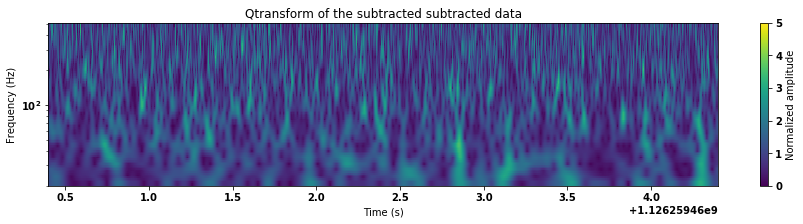

In [91]:
#subtraction of the signal

dt = tmaxS1 - sub11F.start_time
inj = hmaxS1.cyclic_time_shift(dt)

#scale tempplate

inj /= sigma(hmaxS1, psd = psdS1, low_frequency_cutoff = 20.)
inj *= maxsnrS1

subsubF = sub11F - inj

#whiten 

subsub_white = (subsubF/psdS1**0.5).to_timeseries()
zoom = subsub_white.time_slice(merger.time -2, merger.time + 2)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))

plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 2, merger.time + 2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

We see that the signal can well be constrained in this case and that the two mergers are stille enough appart to be seen*

## For 0.5s

Now, the mergers wil probably not be independant anymore and it will become more complicated

In [92]:
# reimport the data to work from scratch again
merger = Merger("GW150914")
strain = merger.strain("H1")
strain = highpass(strain, 15.)
strain = strain.crop(2,2)

strainF = strain.to_frequencyseries()

In [93]:
p5 = strain.psd(2)
p5 = interpolate(p5, strainF.delta_f)
psd5 = inverse_spectrum_truncation(p5, 2*strain.sample_rate,
                                  low_frequency_cutoff = 15.,
                                  trunc_method = 'hann')

In [94]:
#best fit model based on the result from the previous notebook

#freq
hp_f, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = 40.3, 
                         mass2 = 32.3, distance = 440, f_lower = 20., 
                                delta_f = strainF.delta_f)
hp_f.resize(len(strainF))
hp_f.start_time = strainF.start_time

#time
hp_t, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 40.3, 
                         mass2 = 32.3, distance = 440, f_lower = 20., 
                         delta_t = strain.delta_t)
hp_t.resize(len(strain))
hp_t.start_time = strain.start_time

In [95]:
# making the signal with the injection at 0.5 sec
time_shifts = np.arange(5, 20, 0.01)

model_inj = None
max_amp_inj, time_inj, time_dif = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 40.3, 
                              mass2 = 32.3, distance = 440, f_lower = 20.,
                              delta_t = strain.delta_t)
    hpInj.resize(len(strain))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strain.start_time
    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_ev = hpInj.sample_times[ind]
    time_diff = time_ev - merger.time
    if (abs(time_diff - 0.5) < 0.01):
        model_inj = hpInj
        max_amp_inj, time_inj, time_dif_inj = max_amp, time_ev, time_diff


In [96]:
print(model_inj)
print(time_dif_inj)

[ 1.31115646e-28 -1.31162242e-28  1.31208846e-28 ... -1.30975840e-28
  1.31022445e-28 -1.31069040e-28]
0.5084471702575684


In [106]:
#infos about the injection
print("Max amplitude: ", max_amp_inj)
print("time of the merger for the injection: ", time_inj)
print("Time gap between merger and injection: ", time_dif_inj)

('Max amplitude: ', 1.817323281424452e-21)
('time of the merger for the injection: ', 1126259462.9084473)
('Time gap between merger and injection: ', 0.5084471702575684)


In [113]:
sig5 = strain + model_inj

sig5F = sig5.to_frequencyseries()

p5 = sig5.psd(2)
p5 = interpolate(p5, sig5.delta_f)
psd5 = inverse_spectrum_truncation(p5, 2*sig5.sample_rate, 
                                  low_frequency_cutoff = 20.)

Text(0,0.5,'Normalized amplitude')

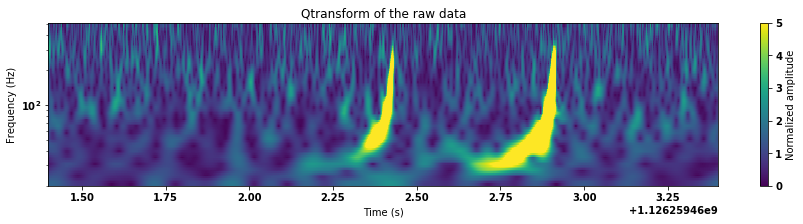

In [114]:
#representation of the two signals

zoom = sig5.whiten(4,4).time_slice(merger.time - 1, merger.time + 1)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange = (20,512),
                             qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 1, merger.time + 1)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

We see that the signal are already closer. However, their banana shape does not overlap yet. SO, we can hope that the overlap is low enough to still be able to distinguish them

In [119]:
import numpy as np

mass1 = np.arange(32.5, 42.1, 0.1)
mass2 = np.arange(29.1, 34.1, 0.1)

hmax5 =  None
maxsnr5, m1max5, m2max5, tmax5 = 0, 0, 0, 0

snrs5 = [[] for i in range(len(mass1))]
max_snrs5 = [[] for i in range(len(mass1))]
times_max5 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1: %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate the weveform with the correct masses
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", 
                                mass1 = m1, mass2 = m2, 
                                distance = 440, f_lower = 20., 
                                delta_f = sig5F.delta_f)
        hp.resize(len(sig5F))
        
        snr = matched_filter(hp, sig5F, psd = psd5 ,
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 10, merger.time + 10)
        snrs5[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs5[i].append(snrp)
        time = snr.sample_times[idx]
        times_max5[i].append(time)
        
        # Keep track of the max snr
        
        if snrp > maxsnr5:
            tmax5, hmax5, m1max5, m2max5, maxsnr5 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1max5, m2max5, tmax5, maxsnr5))
print(time_inj)

Mass1: 1/97
Done
Mass1: 2/97
Done
Mass1: 3/97
Done
Mass1: 4/97
Done
Mass1: 5/97
Done
Mass1: 6/97
Done
Mass1: 7/97
Done
Mass1: 8/97
Done
Mass1: 9/97
Done
Mass1: 10/97
Done
Mass1: 11/97
Done
Mass1: 12/97
Done
Mass1: 13/97
Done
Mass1: 14/97
Done
Mass1: 15/97
Done
Mass1: 16/97
Done
Mass1: 17/97
Done
Mass1: 18/97
Done
Mass1: 19/97
Done
Mass1: 20/97
Done
Mass1: 21/97
Done
Mass1: 22/97
Done
Mass1: 23/97
Done
Mass1: 24/97
Done
Mass1: 25/97
Done
Mass1: 26/97
Done
Mass1: 27/97
Done
Mass1: 28/97
Done
Mass1: 29/97
Done
Mass1: 30/97
Done
Mass1: 31/97
Done
Mass1: 32/97
Done
Mass1: 33/97
Done
Mass1: 34/97
Done
Mass1: 35/97
Done
Mass1: 36/97
Done
Mass1: 37/97
Done
Mass1: 38/97
Done
Mass1: 39/97
Done
Mass1: 40/97
Done
Mass1: 41/97
Done
Mass1: 42/97
Done
Mass1: 43/97
Done
Mass1: 44/97
Done
Mass1: 45/97
Done
Mass1: 46/97
Done
Mass1: 47/97
Done
Mass1: 48/97
Done
Mass1: 49/97
Done
Mass1: 50/97
Done
Mass1: 51/97
Done
Mass1: 52/97
Done
Mass1: 53/97
Done
Mass1: 54/97
Done
Mass1: 55/97
Done
Mass1: 56/97
Done
M

Text(0,0.5,'Normalized amplitude')

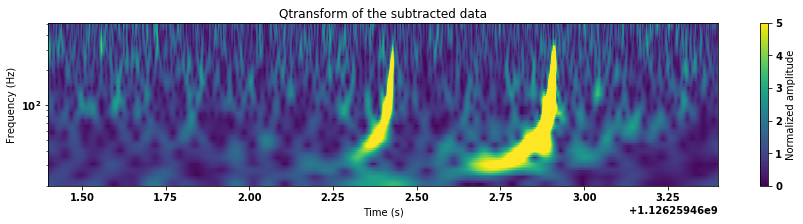

In [122]:
#xheck if the sibtraction could work

dt = tmax5 - sig5F.start_time
inj = hmax5.cyclic_time_shift(dt)

#scaling of the template 
inj /= sigma(hmax5, psd = psd5, low_frequency_cutoff = 20.)
inj *= maxsnr5

#subtraction
sub5F = sig5F - inj

#whiten
subT_white5 = (sub5F/psd5**0.5).to_timeseries()
zoom = subT_white5.time_slice(merger.time - 1, merger.time + 1)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 1, merger.time + 1)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

As we expected, the simple subtraction does not work

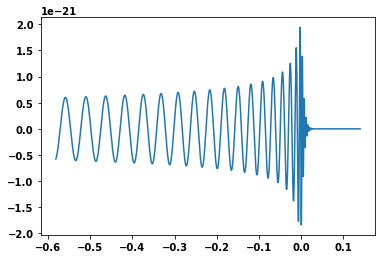

In [123]:
#starting model that wil be adjusted:

hp_st5, hf_st5 = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1max5,
                              mass2 = m2max5, distance = 440, delta_t = sig5.delta_t,
                              f_lower = f_low)
plt.plot(hp_st5.sample_times, hp_st5)

Text(0.5,1,'Whitened data of GW150914 with the signal injected at 5 s')

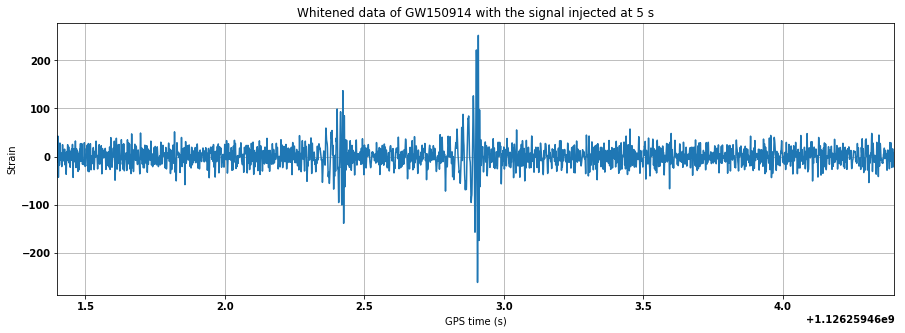

In [125]:
#whitening of the data
white_sig5 =  (sig5F/psd5**0.5).to_timeseries()
white_sig5 = white_sig5.highpass_fir(30., 512).lowpass_fir(300, 512)
white_sig5 = white_sig5.time_slice(merger.time - 1, merger.time + 2)

plt.figure(figsize = [15, 5])
plt.plot(white_sig5.sample_times, white_sig5)
plt.xlim(merger.time - 1, merger.time + 2)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.grid()
plt.title("Whitened data of GW150914 with the signal injected at 5 s")

In [131]:
def gen_template(theta, delta_t = sig5.delta_t, 
                 duration = sig5.duration, start_time = sig5.start_time,
                 f_lower = f_low):
    
    #unpack values used to adapt the template
    m1, m2, dist, time = theta
    
    #make the templayte with the values provided and adjust it to data
    hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1,
                            mass2 = m2, distance = dist, 
                             delta_t = delta_t, f_lower = f_low)
    
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - sig5.start_time)
    hp.start_time = sig5.start_time
    
    return hp

In [132]:
from pycbc.filter import get_cutoff_indices as get_ind

def loglikelihood(theta, df = sig5F, f_lower = f_low, f_upper = f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t = df.delta_t, 
                            f_lower = f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = get_ind(f_lower, f_upper, df.delta_f,
                                          (N-1)*2)
    
    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj() * hf[kmin:kmax]).real()/psd5[kmin:kmax])
    dh = sum (4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd5[kmin:kmax])
    
    logl = -0.5*(hh - 2.0*dh)
    
    return logl

In [133]:
def whiten_trim_template(template, psd = psd5):
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd5**0.5).to_timeseries()
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    white_temp = white_temp.time_slice(merger.time - 1, merger.time + 5)
    
    return white_temp

def plot_white_strain(strain, template, zoom):
    white_data = (sig5F/psd5**0.5).to_timeseries()
    
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd5 **0.5).to_timeseries()
    
    white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data = white_data.time_slice(merger.time - 1, merger.time + 5)
    white_temp = white_temp.time_slice(merger.time - 1, merger.time + 5)
    
    plt.figure(figsize = [15 , 3])
    plt.plot(white_data.sample_times, white_data, label = 'data')
    plt.plot(white_temp.sample_times, white_temp, label = 'template')
    plt.legend()
    plt.grid()
    plt.title("Superposition data and template")
    plt.ylabel("Strain")
    plt.xlabel("GPS time (s)")
    
    if zoom is True:
        plt.xlim(merger.time - 0.5, merger.time + 1)
    if zoom is False:
        plt.xlim(merger.time - 1, merger.time + 2)
        

-464.76919532281534


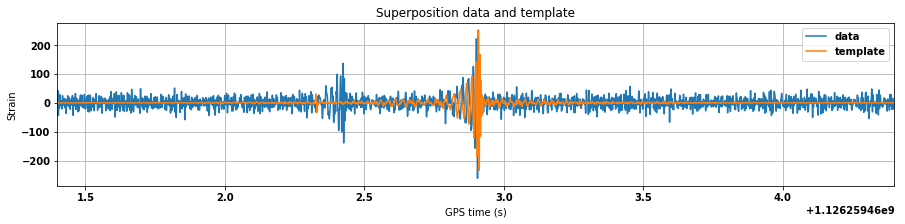

In [134]:
#initialisation of the values to those found with the matched filtering

theta0 = [m1max5, m2max5, 440, tmax5]

temp0 = gen_template(theta0)
plot_white_strain(sig5, temp0, False)

print(loglikelihood(theta0))

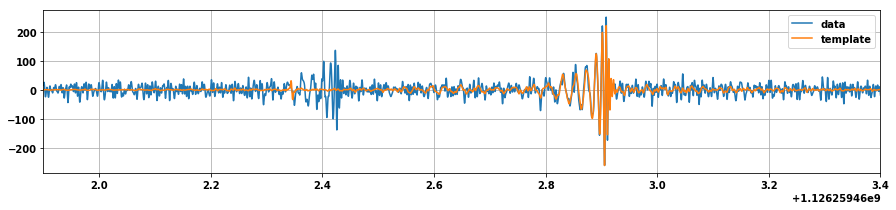

Steps 	 log(likelihood)
7 	 627.421


In [135]:
#best fit to adapt the found parameters to the signal
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize = [15, 3])
Neval = 1

white_temp = whiten_trim_template(gen_template(theta0))

plt.plot(white_sig5.sample_times, white_sig5, label = 'data')
line, = plt.plot(white_temp.sample_times, white_temp, label = 'template')

plt.xlim(merger.time - 0.5, merger.time + 1)
plt.grid()
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    temp = gen_template(thetai)
    white_temp = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_temp)
    
    clear_output(wait = True)
    display(fig)
    print("Steps \t log(likelihood)")
    print("%i \t %.3f" %(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta : -loglikelihood(theta), theta0, 
              callback = callback, method = 'powell')
plt.close()

[4.24035797e+01 3.27372634e+01 4.40397922e+02 1.12625946e+09]


Text(0.5,1,'Whitened signal with best fit template superposed')

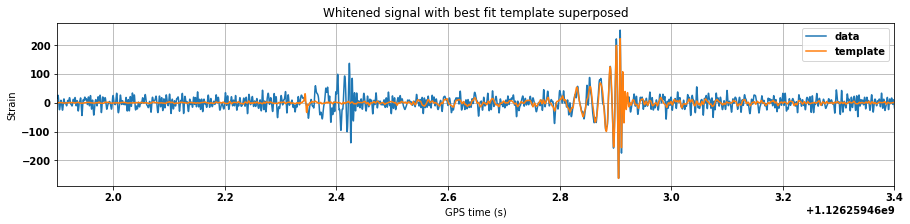

In [137]:
para5 = res.x
print(para5)
best_temp = gen_template(para5)
plot_white_strain(sig5, best_temp, True)
plt.title("Whitened signal with best fit template superposed")

Text(0,0.5,'Normalized amplitude')

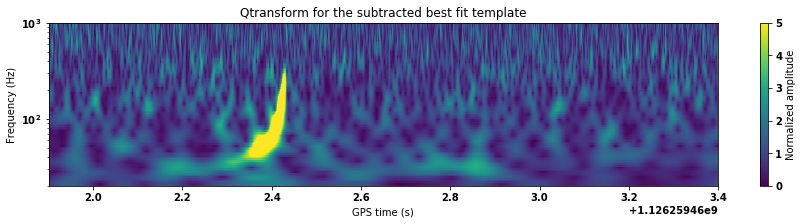

In [138]:
#do the subtraction of the best fit signal

sub5 = sig5 - best_temp

t, f, p = sub5.whiten(4,4).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))

plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted best fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 0.5, merger.time + 1)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

We see that the signal has well been subtracted.

We stll try to locate the other signal to see if it works and provide the correct result

In [139]:
pf = sub5.psd(2)
pf = interpolate(pf, sub5.delta_f)
psdS5 = inverse_spectrum_truncation(pf, 2*sub5.sample_rate,
                                   low_frequency_cutoff = 15.,
                                   trunc_method = 'hann')

In [140]:
sub5F = sub5.to_frequencyseries()

In [143]:
#matched filtering for the event

mass1 = np.arange(32.5, 40.4, 0.1)
mass2 = np.arange(29.1, 32.4, 0.1)

hmaxS5 = None
maxsnrS5, m1maxS5, m2maxS5, tmaxS5 = 0, 0, 0, 0

snrsS5 = [[] for i in range(len(mass1))]
max_snrsS5 = [[] for i in range(len(mass1))]
time_maxS5 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass 1: %i/%i" %(i+1,len(mass1)))
    for m2 in mass2:
        #template generation
        hp, _ = get_fd_waveform(approximant = 'IMRPhenomD', mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20.,
                               delta_f = sub5F.delta_f)
        hp.resize(len(sub5F))
        
        #matched filtering
        snr = matched_filter(hp, sub5F, psd = psdS5, 
                             low_frequency_cutoff = 20.)
        snr = snr.time_slice(merger.time - 5, merger.time + 10)
        snrsS5[i].append(snr)
        ind = abs(snr).numpy().argmax()
        snrp = abs(snr[ind])
        max_snrsS5[i].append(snrp)
        time = snr.sample_times[ind]
        time_maxS5[i].append(time)
        
        #keep track of max snr
        
        if snrp > maxsnrS5:
            tmaxS5, hmaxS5, m1maxS5, m2maxS5, maxsnrS5 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.2f and m2 = %.2f at time %.7f with a value of %.7f" %(m1maxS5, m2maxS5, tmaxS5, maxsnrS5))

Mass 1: 1/79
Done
Mass 1: 2/79
Done
Mass 1: 3/79
Done
Mass 1: 4/79
Done
Mass 1: 5/79
Done
Mass 1: 6/79
Done
Mass 1: 7/79
Done
Mass 1: 8/79
Done
Mass 1: 9/79
Done
Mass 1: 10/79
Done
Mass 1: 11/79
Done
Mass 1: 12/79
Done
Mass 1: 13/79
Done
Mass 1: 14/79
Done
Mass 1: 15/79
Done
Mass 1: 16/79
Done
Mass 1: 17/79
Done
Mass 1: 18/79
Done
Mass 1: 19/79
Done
Mass 1: 20/79
Done
Mass 1: 21/79
Done
Mass 1: 22/79
Done
Mass 1: 23/79
Done
Mass 1: 24/79
Done
Mass 1: 25/79
Done
Mass 1: 26/79
Done
Mass 1: 27/79
Done
Mass 1: 28/79
Done
Mass 1: 29/79
Done
Mass 1: 30/79
Done
Mass 1: 31/79
Done
Mass 1: 32/79
Done
Mass 1: 33/79
Done
Mass 1: 34/79
Done
Mass 1: 35/79
Done
Mass 1: 36/79
Done
Mass 1: 37/79
Done
Mass 1: 38/79
Done
Mass 1: 39/79
Done
Mass 1: 40/79
Done
Mass 1: 41/79
Done
Mass 1: 42/79
Done
Mass 1: 43/79
Done
Mass 1: 44/79
Done
Mass 1: 45/79
Done
Mass 1: 46/79
Done
Mass 1: 47/79
Done
Mass 1: 48/79
Done
Mass 1: 49/79
Done
Mass 1: 50/79
Done
Mass 1: 51/79
Done
Mass 1: 52/79
Done
Mass 1: 53/79
Done
Ma

In [144]:
print(merger.time)

1126259462.4


Text(0,0.5,'Normalized amplitude')

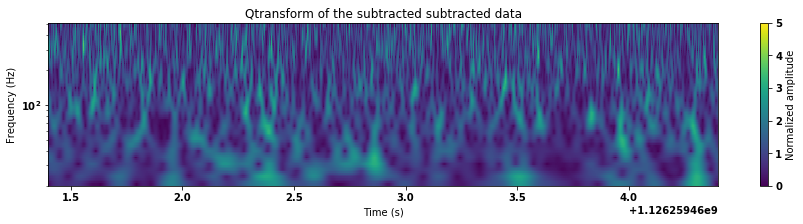

In [148]:
#see if the data can directly be subtracted out of the data,
#else fitting


dt = tmaxS5 - sub5F.start_time
inj = hmaxS5.cyclic_time_shift(dt)

#scale tempplate

inj /= sigma(hmaxS5, psd = psdS5, low_frequency_cutoff = 20.)
inj *= maxsnrS5

subsubF5 = sub5F - inj

#whiten 

subsub_white5 = (subsubF5/psdS5**0.5).to_timeseries()
zoom = subsub_white5.time_slice(merger.time -1, merger.time + 2)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))

plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 1, merger.time + 2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

The subtraction of the signal out of the data still works and the two events are found separatedly

## For 0.25 seconds

Seen the distance in the previous case, this should give overlap

In [3]:
merger = Merger("GW150914")
strain = merger.strain("H1")
strain = highpass(strain, 15)
strain = strain.crop(2,2)

strainF = strain.to_frequencyseries()

In [5]:
p25 = strain.psd(2)
p25 = interpolate(p25, strainF.delta_f)
psd25 = inverse_spectrum_truncation(p25, 2*strain.sample_rate,
                                  low_frequency_cutoff = 15.,
                                  trunc_method = 'hann')

In [6]:
# making the signal with the injection at 0.25 sec
time_shifts = np.arange(5, 20, 0.01)

model_inj = None
max_amp_inj, time_inj, time_dif = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 40.3, 
                              mass2 = 32.3, distance = 440, f_lower = 20.,
                              delta_t = strain.delta_t)
    hpInj.resize(len(strain))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strain.start_time
    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_ev = hpInj.sample_times[ind]
    time_diff = time_ev - merger.time
    if (abs(time_diff - 0.25) < 0.1):
        model_inj = hpInj
        max_amp_inj, time_inj, time_dif_inj = max_amp, time_ev, time_diff


In [7]:
print(model_inj)
print(time_dif_inj)

[-2.24655871e-28  2.24720816e-28 -2.24785762e-28 ...  2.24461037e-28
 -2.24525982e-28  2.24590926e-28]
0.34853506088256836


In [8]:
#infos about the injection
print("Max amplitude: ", max_amp_inj)
print("time of the merger for the injection: ", time_inj)
print("Time gap between merger and injection: ", time_dif_inj)

('Max amplitude: ', 1.824552401847099e-21)
('time of the merger for the injection: ', 1126259462.7485352)
('Time gap between merger and injection: ', 0.34853506088256836)


In [9]:
#now we add the injection in the strain 

sig25 = strain + model_inj

sigF25 = sig25.to_frequencyseries()

p25 = sig25.psd(2)
p25 = interpolate(p25, sig25.delta_f)
psd25 = inverse_spectrum_truncation(p25, 2*sig25.sample_rate, 
                                 low_frequency_cutoff = 20.)

/home/justin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0,0.5,'Normalized amplitude')

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


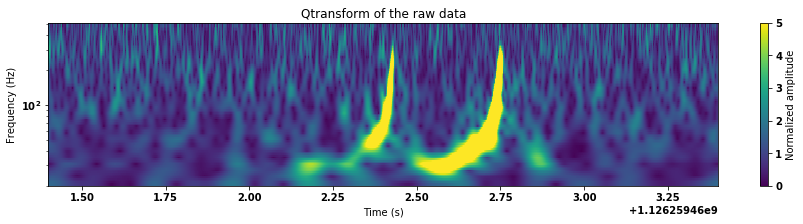

In [10]:
zoom = sig25.whiten(4,4).time_slice(merger.time - 1, merger.time + 1)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange = (20,512),
                             qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 1, merger.time + 1)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

We see that the banana shapes are becoming really close in this case

In [11]:
#trial to detect the first signal

import numpy as np

mass1 = np.arange(32.5, 40.4, 0.1)
mass2 = np.arange(29.7, 32.4, 0.1)

hmax25 = None
maxsnr25, m1max25, m2max25, tmax25 = 0, 0, 0, 0

snrs25 = [[] for i in range(len(mass1))]
max_snrs25 = [[] for i in range(len(mass1))]
times_max25 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF25.delta_f)
        hp.resize(len(sigF25))
        
        snr = matched_filter(hp, sigF25, psd = psd25, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 5, merger.time + 5)
        snrs25[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs25[i].append(snrp)
        time = snr.sample_times[idx]
        times_max25[i].append(time)
        
        # Keep track of the max snr
        
        if snrp > maxsnr25:
            tmax25, hmax25, m1max25, m2max25, maxsnr25 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1max25, m2max25, tmax25, maxsnr25))
print(time_inj)

mass 1 1/79
Done
mass 1 2/79
Done
mass 1 3/79
Done
mass 1 4/79
Done
mass 1 5/79
Done
mass 1 6/79
Done
mass 1 7/79
Done
mass 1 8/79
Done
mass 1 9/79
Done
mass 1 10/79
Done
mass 1 11/79
Done
mass 1 12/79
Done
mass 1 13/79
Done
mass 1 14/79
Done
mass 1 15/79
Done
mass 1 16/79
Done
mass 1 17/79
Done
mass 1 18/79
Done
mass 1 19/79
Done
mass 1 20/79
Done
mass 1 21/79
Done
mass 1 22/79
Done
mass 1 23/79
Done
mass 1 24/79
Done
mass 1 25/79
Done
mass 1 26/79
Done
mass 1 27/79
Done
mass 1 28/79
Done
mass 1 29/79
Done
mass 1 30/79
Done
mass 1 31/79
Done
mass 1 32/79
Done
mass 1 33/79
Done
mass 1 34/79
Done
mass 1 35/79
Done
mass 1 36/79
Done
mass 1 37/79
Done
mass 1 38/79
Done
mass 1 39/79
Done
mass 1 40/79
Done
mass 1 41/79
Done
mass 1 42/79
Done
mass 1 43/79
Done
mass 1 44/79
Done
mass 1 45/79
Done
mass 1 46/79
Done
mass 1 47/79
Done
mass 1 48/79
Done
mass 1 49/79
Done
mass 1 50/79
Done
mass 1 51/79
Done
mass 1 52/79
Done
mass 1 53/79
Done
mass 1 54/79
Done
mass 1 55/79
Done
mass 1 56/79
Done
m

Text(0,0.5,'Normalized amplitude')

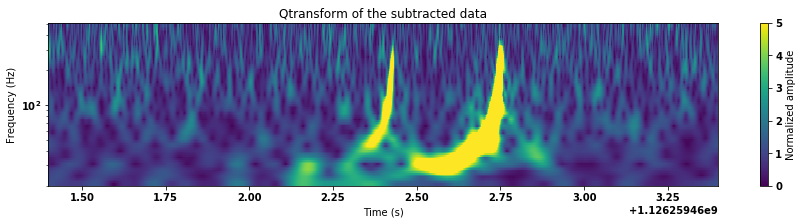

In [13]:
#test the simple subtraction 

dt = tmax25 - sigF25.start_time
inj = hmax25.cyclic_time_shift(dt)

#scaling of the template 
inj /= sigma(hmax25, psd = psd25, low_frequency_cutoff = 20.)
inj *= maxsnr25

#subtraction
sub25F = sigF25 - inj

#whiten
sub25T_white = (sub25F/psd25**0.5).to_timeseries()
zoom = sub25T_white.time_slice(merger.time - 1, merger.time + 1)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 1, merger.time + 1)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [14]:
f_low = 20.
f_upper = 1024.

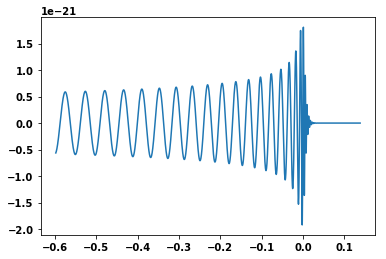

In [15]:
#strting model that wil be adjusted:

hp_st25, hf_st25 = get_td_waveform(approximant = "SEOBNRv4_opt", 
                                   mass1 = m1max25, mass2 = m2max25, 
                                   distance = 440, delta_t = sig25.delta_t,
                              f_lower = f_low)
plt.plot(hp_st25.sample_times, hp_st25)

Text(0.5,1,'Whitened data of GW150914 with the signal injected at 5 s')

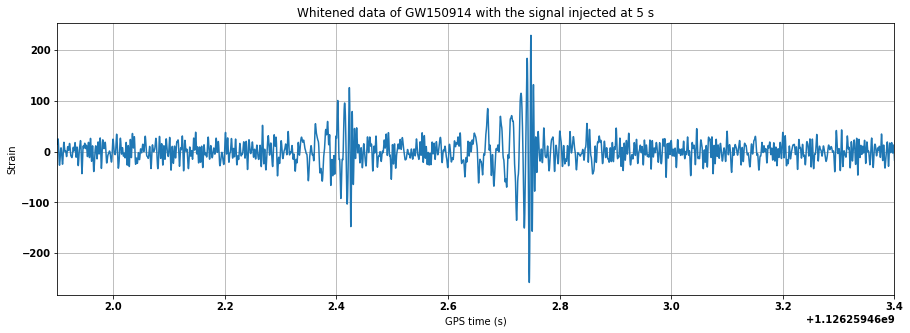

In [18]:
#whitening of the data
white_sig25 =  (sigF25/psd25**0.5).to_timeseries()
white_sig25 = white_sig25.highpass_fir(30., 512).lowpass_fir(300, 512)
white_sig25 = white_sig25.time_slice(merger.time - 1, merger.time + 2)

plt.figure(figsize = [15, 5])
plt.plot(white_sig25.sample_times, white_sig25)
plt.xlim(merger.time - 0.5, merger.time + 1)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.grid()
plt.title("Whitened data of GW150914 with the signal injected at 5 s")

In [19]:
def gen_template(theta, delta_t = sig25.delta_t, 
                 duration = sig25.duration, start_time = sig25.start_time,
                 f_lower = f_low):
    
    #unpack values used to adapt the template
    m1, m2, dist, time = theta
    
    #make the templayte with the values provided and adjust it to data
    hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1,
                            mass2 = m2, distance = dist, 
                             delta_t = delta_t, f_lower = f_low)
    
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - sig25.start_time)
    hp.start_time = sig25.start_time
    
    return hp

In [20]:
from pycbc.filter import get_cutoff_indices as get_ind

def loglikelihood(theta, df = sigF25, f_lower = f_low, f_upper = f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t = df.delta_t, 
                            f_lower = f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = get_ind(f_lower, f_upper, df.delta_f,
                                          (N-1)*2)
    
    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj() * hf[kmin:kmax]).real()/psd25[kmin:kmax])
    dh = sum (4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd25[kmin:kmax])
    
    logl = -0.5*(hh - 2.0*dh)
    
    return logl

In [27]:
def whiten_trim_template(template, psd = psd25):
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd25**0.5).to_timeseries()
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    white_temp = white_temp.time_slice(merger.time - 1, merger.time + 2)
    
    return white_temp

def plot_white_strain(strain, template, zoom):
    white_data = (sigF25/psd25**0.5).to_timeseries()
    
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd25 **0.5).to_timeseries()
    
    white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data = white_data.time_slice(merger.time - 1, merger.time + 2)
    white_temp = white_temp.time_slice(merger.time - 1, merger.time + 2)
    
    plt.figure(figsize = [15 , 3])
    plt.plot(white_data.sample_times, white_data, label = 'data')
    plt.plot(white_temp.sample_times, white_temp, label = 'template')
    plt.legend()
    plt.grid()
    plt.title("Superposition data and template")
    plt.ylabel("Strain")
    plt.xlabel("GPS time (s)")
    
    if zoom is True:
        plt.xlim(merger.time - 0.2, merger.time + 0.5)
    if zoom is False:
        plt.xlim(merger.time - 1, merger.time + 1)
        

-835.5668096241673


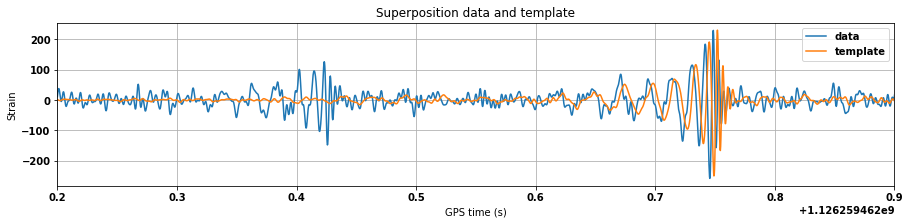

In [28]:
#initialisation of the values to those found with the matched filtering

theta0 = [m1max25, m2max25, 440, tmax25]

temp0 = gen_template(theta0)
plot_white_strain(sig25, temp0, True)

print(loglikelihood(theta0))

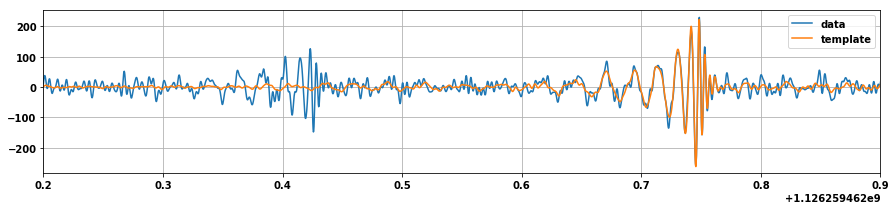

Steps 	 log(likelihood)
7 	 622.925


In [29]:
#best fit to adapt the found parameters to the signal
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize = [15, 3])
Neval = 1

white_temp = whiten_trim_template(gen_template(theta0))

plt.plot(white_sig25.sample_times, white_sig25, label = 'data')
line, = plt.plot(white_temp.sample_times, white_temp, label = 'template')

plt.xlim(merger.time - 0.2, merger.time + 0.5)
plt.grid()
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    temp = gen_template(thetai)
    white_temp = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_temp)
    
    clear_output(wait = True)
    display(fig)
    print("Steps \t log(likelihood)")
    print("%i \t %.3f" %(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta : -loglikelihood(theta), theta0, 
              callback = callback, method = 'powell')
plt.close()

[4.26750050e+01 3.25131480e+01 4.41268472e+02 1.12625946e+09]


Text(0.5,1,'superposition of the white template and the best fit template')

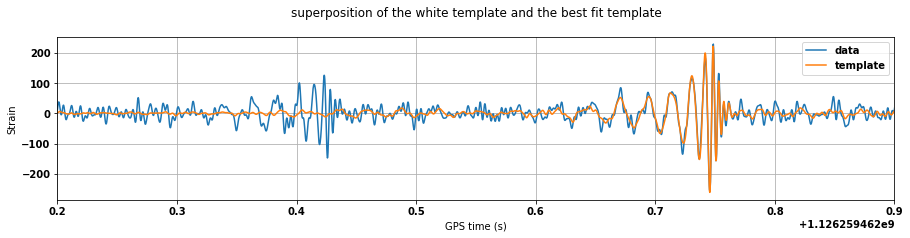

In [30]:
para25 = res.x
print(para25)
best25 = gen_template(para25)
plot_white_strain(sig25, best25, True)
plt.title("superposition of the white template and the best fit template", pad = 20)

Text(0.5,1,'superposition of the white template and the best fit template')

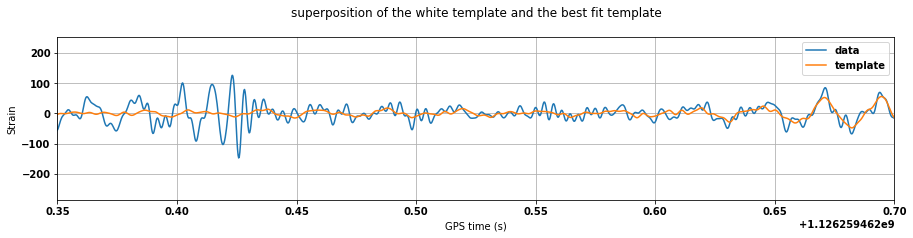

In [32]:
plot_white_strain(sig25, best25, True)
plt.xlim(merger.time-0.05, merger.time + 0.3)
plt.title("superposition of the white template and the best fit template", pad = 20)

Text(0,0.5,'Normalized amplitude')

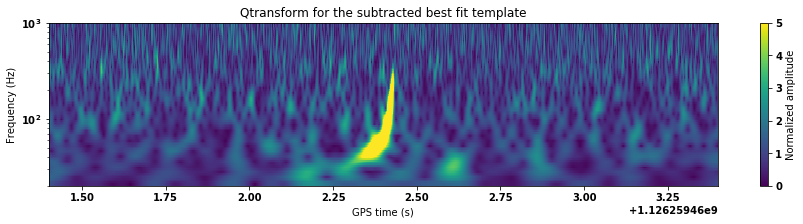

In [36]:
sub25 = sig25 - best25

t, f, p = sub25.whiten(4,4).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted best fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 1, merger.time + 1)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

Text(0,0.5,'Normalized amplitude')

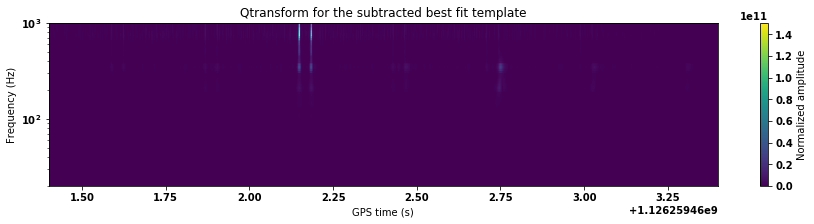

In [62]:
#to compare both, we can subtract the raw signal and the subtracted

test = strain - sub25

t, f, p = test.whiten(4,4).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted best fit template")
im = plt.pcolormesh(t, f, p**0.5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 1, merger.time + 1)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [63]:
#psd of the subtracted data
p = sub25.psd(2)
p = interpolate(p, sub25.delta_f)
psdS25 = inverse_spectrum_truncation(p, 2*sub25.sample_rate, 
                                  low_frequency_cutoff = 15.,
                                  trunc_method = 'hann')

In [64]:
subF25 = sub25.to_frequencyseries()

In [67]:
#matched filtering for the event

mass1 = np.arange(32.5, 40.4, 0.1)
mass2 = np.arange(29.1, 32.4, 0.1)

hmaxS25 = None
maxsnrS25, m1maxS25, m2maxS25, tmaxS25 = 0, 0, 0, 0

snrsS25 = [[] for i in range(len(mass1))]
max_snrsS25 = [[] for i in range(len(mass1))]
time_maxS25 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass 1: %i/%i" %(i+1,len(mass1)))
    for m2 in mass2:
        #template generation
        hp, _ = get_fd_waveform(approximant = 'IMRPhenomD', mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20.,
                               delta_f = subF25.delta_f)
        hp.resize(len(subF25))
        
        #matched filtering
        snr = matched_filter(hp, subF25, psd = psdS25, 
                             low_frequency_cutoff = 20.)
        snr = snr.time_slice(merger.time - 10, merger.time + 10)
        snrsS25[i].append(snr)
        ind = abs(snr).numpy().argmax()
        snrp = abs(snr[ind])
        max_snrsS25[i].append(snrp)
        time = snr.sample_times[ind]
        time_maxS25[i].append(time)
        
        #keep track of max snr
        
        if snrp > maxsnrS25:
            tmaxS25, hmaxS25, m1maxS25, m2maxS25, maxsnrS25 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.2f and m2 = %.2f at time %.7f with a value of %.7f" %(m1maxS25, m2maxS25, tmaxS25, maxsnrS25))
print(merger.time)

Mass 1: 1/79
Done
Mass 1: 2/79
Done
Mass 1: 3/79
Done
Mass 1: 4/79
Done
Mass 1: 5/79
Done
Mass 1: 6/79
Done
Mass 1: 7/79
Done
Mass 1: 8/79
Done
Mass 1: 9/79
Done
Mass 1: 10/79
Done
Mass 1: 11/79
Done
Mass 1: 12/79
Done
Mass 1: 13/79
Done
Mass 1: 14/79
Done
Mass 1: 15/79
Done
Mass 1: 16/79
Done
Mass 1: 17/79
Done
Mass 1: 18/79
Done
Mass 1: 19/79
Done
Mass 1: 20/79
Done
Mass 1: 21/79
Done
Mass 1: 22/79
Done
Mass 1: 23/79
Done
Mass 1: 24/79
Done
Mass 1: 25/79
Done
Mass 1: 26/79
Done
Mass 1: 27/79
Done
Mass 1: 28/79
Done
Mass 1: 29/79
Done
Mass 1: 30/79
Done
Mass 1: 31/79
Done
Mass 1: 32/79
Done
Mass 1: 33/79
Done
Mass 1: 34/79
Done
Mass 1: 35/79
Done
Mass 1: 36/79
Done
Mass 1: 37/79
Done
Mass 1: 38/79
Done
Mass 1: 39/79
Done
Mass 1: 40/79
Done
Mass 1: 41/79
Done
Mass 1: 42/79
Done
Mass 1: 43/79
Done
Mass 1: 44/79
Done
Mass 1: 45/79
Done
Mass 1: 46/79
Done
Mass 1: 47/79
Done
Mass 1: 48/79
Done
Mass 1: 49/79
Done
Mass 1: 50/79
Done
Mass 1: 51/79
Done
Mass 1: 52/79
Done
Mass 1: 53/79
Done
Ma

Text(0,0.5,'Normalized amplitude')

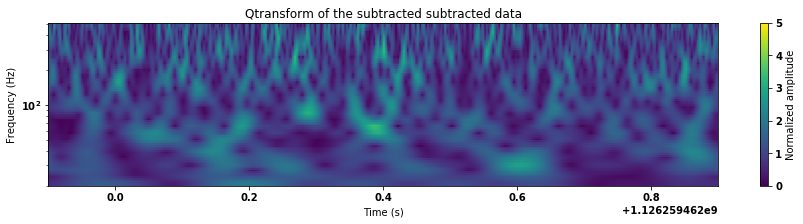

In [69]:
dt = tmaxS25 - subF25.start_time
inj = hmaxS25.cyclic_time_shift(dt)

#scale tempplate

inj /= sigma(hmaxS25, psd = psdS25, low_frequency_cutoff = 20.)
inj *= maxsnrS25

subsubF25 = subF25 - inj

#whiten 

subsub_white25 = (subsubF25/psdS25**0.5).to_timeseries()
zoom = subsub_white25.time_slice(merger.time -0.5, merger.time + 0.5)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))

plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 0.5, merger.time + 0.5)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

## For 0.1 sec

Now, the merging should be totally effective

In [3]:
merger = Merger("GW150914")
strain = merger.strain("H1")
strain = highpass(strain, 15)
strain = strain.crop(2,2)

strainF = strain.to_frequencyseries()


In [4]:
p = strain.psd(2)
p = interpolate(p, strainF.delta_f)
psd = inverse_spectrum_truncation(p, 2*strain.sample_rate, 
                                  low_frequency_cutoff = 15., 
                                  trunc_method = 'hann')

In [5]:
# making the signal with the injection at 5 sec
time_shifts = np.arange(5, 20, 0.01)

model_inj = None
max_amp_inj, time_inj, time_dif = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 40.3, 
                              mass2 = 32.3, distance = 440, f_lower = 20.,
                              delta_t = strain.delta_t)
    hpInj.resize(len(strain))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strain.start_time
    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_ev = hpInj.sample_times[ind]
    time_diff = time_ev - merger.time
    if (abs(time_diff - 0.1) < 0.01):
        model_inj = hpInj
        max_amp_inj, time_inj, time_dif_inj = max_amp, time_ev, time_diff


In [6]:
print(model_inj)
print(time_dif_inj)

[ 2.74647463e-28 -2.74709614e-28  2.74771769e-28 ... -2.74461004e-28
  2.74523159e-28 -2.74585308e-28]
0.10854482650756836


In [7]:
#infos about the injection
print("Max amplitude: ", max_amp_inj)
print("time of the merger for the injection: ", time_inj)
print("Time gap between merger and injection: ", time_dif_inj)

('Max amplitude: ', 1.8240674338848867e-21)
('time of the merger for the injection: ', 1126259462.508545)
('Time gap between merger and injection: ', 0.10854482650756836)


In [8]:
#now we add the injection in the strain 

sig10 = strain + model_inj

sigF10 = sig10.to_frequencyseries()

p1 = sig10.psd(2)
p1 = interpolate(p1, sig10.delta_f)
psd10 = inverse_spectrum_truncation(p1, 2*sig10.sample_rate, 
                                 low_frequency_cutoff = 20.)

/home/justin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0,0.5,'Normalized amplitude')

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


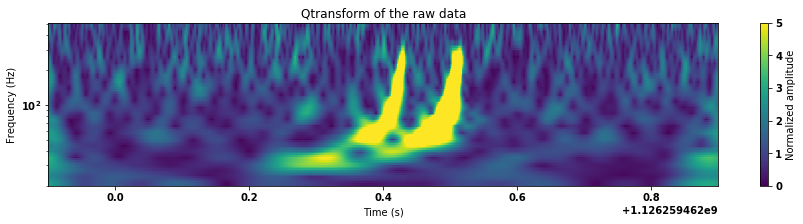

In [9]:
# qtransform of the data to see what it looks like

zoom = sig10.whiten(2,2).time_slice(merger.time - 0.5, merger.time + 0.5)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange = (20,512),
                             qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 0.5, merger.time + 0.5)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [10]:
import numpy as np

mass1 = np.arange(32.5, 40.4, 0.1)
mass2 = np.arange(29.7, 32.4, 0.1)

hmax10 = None
maxsnr10, m1max10, m2max10, tmax10 = 0, 0, 0, 0

snrs10 = [[] for i in range(len(mass1))]
max_snrs10 = [[] for i in range(len(mass1))]
times_max10 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = strainF.delta_f)
        hp.resize(len(sigF10))
        
        snr = matched_filter(hp, sigF10, psd = psd10, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 10, merger.time + 10)
        snrs10[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs10[i].append(snrp)
        time = snr.sample_times[idx]
        times_max10[i].append(time)
        
        # Keep track of the max snr
        
        if snrp > maxsnr10:
            tmax10, hmax10, m1max10, m2max10, maxsnr10 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1max10, m2max10, tmax10, maxsnr10))
print(time_inj)

mass 1 1/79
Done
mass 1 2/79
Done
mass 1 3/79
Done
mass 1 4/79
Done
mass 1 5/79
Done
mass 1 6/79
Done
mass 1 7/79
Done
mass 1 8/79
Done
mass 1 9/79
Done
mass 1 10/79
Done
mass 1 11/79
Done
mass 1 12/79
Done
mass 1 13/79
Done
mass 1 14/79
Done
mass 1 15/79
Done
mass 1 16/79
Done
mass 1 17/79
Done
mass 1 18/79
Done
mass 1 19/79
Done
mass 1 20/79
Done
mass 1 21/79
Done
mass 1 22/79
Done
mass 1 23/79
Done
mass 1 24/79
Done
mass 1 25/79
Done
mass 1 26/79
Done
mass 1 27/79
Done
mass 1 28/79
Done
mass 1 29/79
Done
mass 1 30/79
Done
mass 1 31/79
Done
mass 1 32/79
Done
mass 1 33/79
Done
mass 1 34/79
Done
mass 1 35/79
Done
mass 1 36/79
Done
mass 1 37/79
Done
mass 1 38/79
Done
mass 1 39/79
Done
mass 1 40/79
Done
mass 1 41/79
Done
mass 1 42/79
Done
mass 1 43/79
Done
mass 1 44/79
Done
mass 1 45/79
Done
mass 1 46/79
Done
mass 1 47/79
Done
mass 1 48/79
Done
mass 1 49/79
Done
mass 1 50/79
Done
mass 1 51/79
Done
mass 1 52/79
Done
mass 1 53/79
Done
mass 1 54/79
Done
mass 1 55/79
Done
mass 1 56/79
Done
m

Text(0,0.5,'Normalized amplitude')

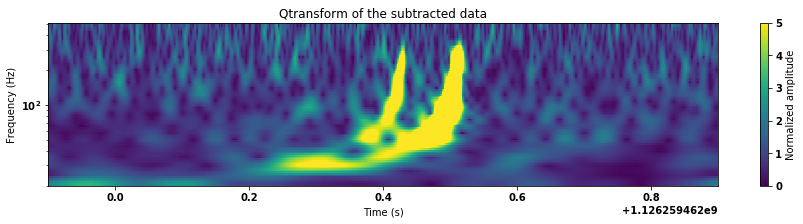

In [11]:
#subtraction of the signal to see if it works

dt = tmax10 - sigF10.start_time
inj = hmax10.cyclic_time_shift(dt)

#scaling of the template 
inj /= sigma(hmax10, psd = psd10, low_frequency_cutoff = 20.)
inj *= maxsnr10

#subtraction
subF10 = sigF10 - inj

#whiten
subT_white10 = (subF10/psd10**0.5).to_timeseries()
zoom = subT_white10.time_slice(merger.time - 0.5, merger.time + 0.5)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 0.5, merger.time + 0.5)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [12]:
f_low = 20.
f_upper = 1024.

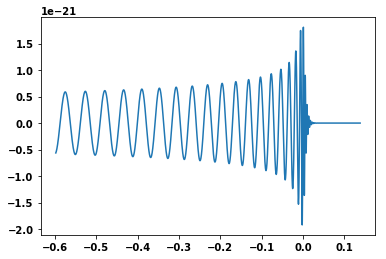

In [13]:

hp_st10, hf_st10 = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1max10,
                              mass2 = m2max10, distance = 440, delta_t = sig10.delta_t,
                              f_lower = f_low)
plt.plot(hp_st10.sample_times, hp_st10)

Text(0.5,1,'Whitened data of GW150914 with the signal injected at 0.1 s')

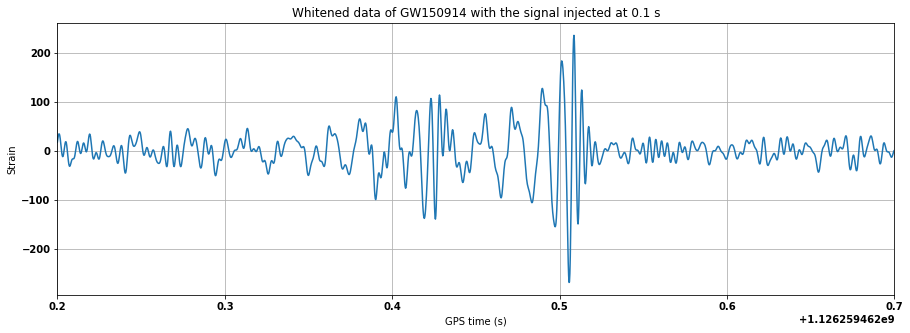

In [14]:
#whitening of the data
white_sig10 =  (sigF10/psd10**0.5).to_timeseries()
white_sig10 = white_sig10.highpass_fir(30., 512).lowpass_fir(300, 512)
white_sig10 = white_sig10.time_slice(merger.time - 1, merger.time + 1)

plt.figure(figsize = [15, 5])
plt.plot(white_sig10.sample_times, white_sig10)
plt.xlim(merger.time - 0.2, merger.time + 0.3)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.grid()
plt.title("Whitened data of GW150914 with the signal injected at 0.1 s")

In [15]:
def gen_template(theta, delta_t = sig10.delta_t, 
                 duration = sig10.duration, start_time = sig10.start_time,
                 f_lower = f_low):
    
    #unpack values used to adapt the template
    m1, m2, dist, time = theta
    
    #make the templayte with the values provided and adjust it to data
    hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1,
                            mass2 = m2, distance = dist, 
                             delta_t = delta_t, f_lower = f_low)
    
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - sig10.start_time)
    hp.start_time = sig10.start_time
    
    return hp

In [16]:
from pycbc.filter import get_cutoff_indices as get_ind

def loglikelihood(theta, df = sigF10, f_lower = f_low, f_upper = f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t = df.delta_t, 
                            f_lower = f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = get_ind(f_lower, f_upper, df.delta_f,
                                          (N-1)*2)
    
    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj() * hf[kmin:kmax]).real()/psd10[kmin:kmax])
    dh = sum (4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd10[kmin:kmax])
    
    logl = -0.5*(hh - 2.0*dh)
    
    return logl

In [17]:
def whiten_trim_template(template, psd = psd10):
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd**0.5).to_timeseries()
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 10)
    
    return white_temp

def plot_white_strain(strain, template, zoom):
    white_data = (sigF10/psd10**0.5).to_timeseries()
    
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd10 **0.5).to_timeseries()
    
    white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data = white_data.time_slice(merger.time - 1, merger.time + 1)
    white_temp = white_temp.time_slice(merger.time - 1, merger.time + 1)
    
    plt.figure(figsize = [15 , 3])
    plt.plot(white_data.sample_times, white_data, label = 'data')
    plt.plot(white_temp.sample_times, white_temp, label = 'template')
    plt.legend()
    plt.grid()
    plt.title("Superposition data and template")
    plt.ylabel("Strain")
    plt.xlabel("GPS time (s)")
    
    if zoom is True:
        plt.xlim(merger.time - 0.2, merger.time + 0.3)
    if zoom is False:
        plt.xlim(merger.time - 0.5, merger.time + 1)
        

-838.9474003792756


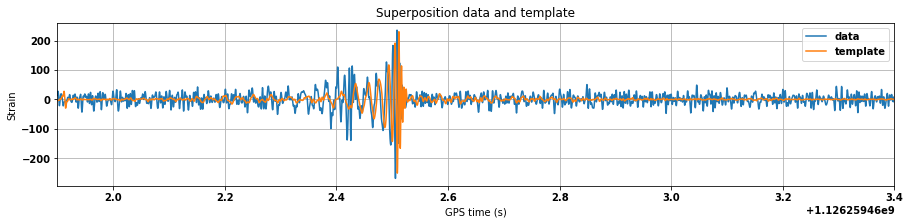

In [18]:
theta0 = [m1max10, m2max10, 440, tmax10]

temp0 = gen_template(theta0)
plot_white_strain(sig10, temp0, False)

print(loglikelihood(theta0))

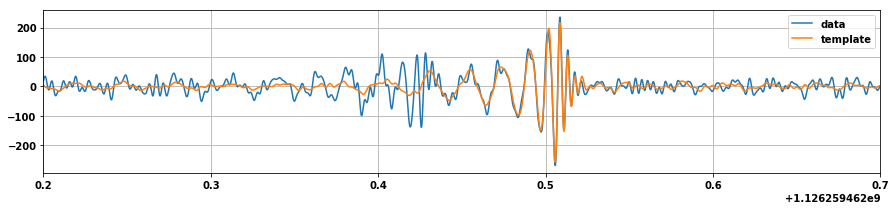

Steps 	 log(likelihood)
10 	 603.706


In [19]:
#best fit to adapt the found parameters to the signal
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize = [15, 3])
Neval = 1

white_temp = whiten_trim_template(gen_template(theta0))

plt.plot(white_sig10.sample_times, white_sig10, label = 'data')
line, = plt.plot(white_temp.sample_times, white_temp, label = 'template')

plt.xlim(merger.time - 0.2, merger.time + 0.3)
plt.grid()
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    temp = gen_template(thetai)
    white_temp = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_temp)
    
    clear_output(wait = True)
    display(fig)
    print("Steps \t log(likelihood)")
    print("%i \t %.3f" %(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta : -loglikelihood(theta), theta0, 
              callback = callback, method = 'powell')
plt.close()

[4.26910954e+01 3.25207795e+01 4.50618315e+02 1.12625946e+09]


Text(0.5,1,'Whitened signal with best fit template superposed')

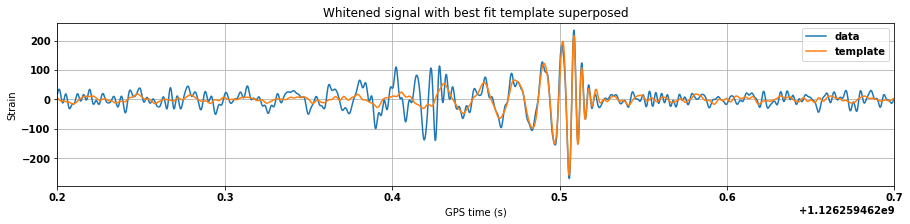

In [20]:
param10 = res.x
print(param10)
best_fit_temp10 = gen_template(param10)
plot_white_strain(sig10, best_fit_temp10, True)
plt.title("Whitened signal with best fit template superposed")

Text(0,0.5,'Normalized amplitude')

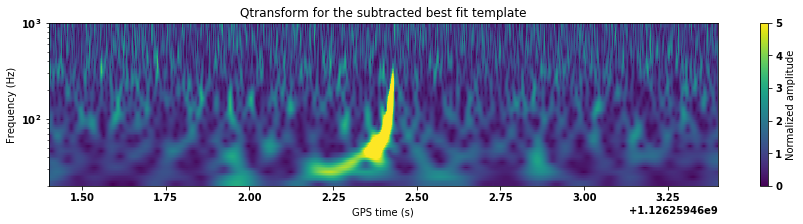

In [22]:
sub10 = sig10 - best_fit_temp10


t, f, p = sub10.whiten(4,4).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted best fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 1, merger.time + 1)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [24]:
#psd of the subtracted data
p10 = sub10.psd(2)
p10 = interpolate(p10, sub10.delta_f)
psdS10 = inverse_spectrum_truncation(p10, 2*sub10.sample_rate, 
                                  low_frequency_cutoff = 15.,
                                  trunc_method = 'hann')

In [25]:
#subtracted signal in the frequency domain
subF10 = sub10.to_frequencyseries()

In [26]:
#try to find and subtract the other event

#matched filtering for the event

mass1 = np.arange(32.5, 40.4, 0.1)
mass2 = np.arange(29.1, 32.4, 0.1)

hmaxS10 = None
maxsnrS10, m1maxS10, m2maxS10, tmaxS10 = 0, 0, 0, 0

snrsS10 = [[] for i in range(len(mass1))]
max_snrsS10 = [[] for i in range(len(mass1))]
time_maxS10 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass 1: %i/%i" %(i+1,len(mass1)))
    for m2 in mass2:
        #template generation
        hp, _ = get_fd_waveform(approximant = 'IMRPhenomD', mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20.,
                               delta_f = subF10.delta_f)
        hp.resize(len(subF10))
        
        #matched filtering
        snr = matched_filter(hp, subF10, psd = psdS10, 
                             low_frequency_cutoff = 20.)
        snr = snr.time_slice(merger.time - 10, merger.time + 10)
        snrsS10[i].append(snr)
        ind = abs(snr).numpy().argmax()
        snrp = abs(snr[ind])
        max_snrsS10[i].append(snrp)
        time = snr.sample_times[ind]
        time_maxS10[i].append(time)
        
        #keep track of max snr
        
        if snrp > maxsnrS10:
            tmaxS10, hmaxS10, m1maxS10, m2maxS10, maxsnrS10 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.2f and m2 = %.2f at time %.7f with a value of %.7f" %(m1maxS10, m2maxS10, tmaxS10, maxsnrS10))

Mass 1: 1/79
Done
Mass 1: 2/79
Done
Mass 1: 3/79
Done
Mass 1: 4/79
Done
Mass 1: 5/79
Done
Mass 1: 6/79
Done
Mass 1: 7/79
Done
Mass 1: 8/79
Done
Mass 1: 9/79
Done
Mass 1: 10/79
Done
Mass 1: 11/79
Done
Mass 1: 12/79
Done
Mass 1: 13/79
Done
Mass 1: 14/79
Done
Mass 1: 15/79
Done
Mass 1: 16/79
Done
Mass 1: 17/79
Done
Mass 1: 18/79
Done
Mass 1: 19/79
Done
Mass 1: 20/79
Done
Mass 1: 21/79
Done
Mass 1: 22/79
Done
Mass 1: 23/79
Done
Mass 1: 24/79
Done
Mass 1: 25/79
Done
Mass 1: 26/79
Done
Mass 1: 27/79
Done
Mass 1: 28/79
Done
Mass 1: 29/79
Done
Mass 1: 30/79
Done
Mass 1: 31/79
Done
Mass 1: 32/79
Done
Mass 1: 33/79
Done
Mass 1: 34/79
Done
Mass 1: 35/79
Done
Mass 1: 36/79
Done
Mass 1: 37/79
Done
Mass 1: 38/79
Done
Mass 1: 39/79
Done
Mass 1: 40/79
Done
Mass 1: 41/79
Done
Mass 1: 42/79
Done
Mass 1: 43/79
Done
Mass 1: 44/79
Done
Mass 1: 45/79
Done
Mass 1: 46/79
Done
Mass 1: 47/79
Done
Mass 1: 48/79
Done
Mass 1: 49/79
Done
Mass 1: 50/79
Done
Mass 1: 51/79
Done
Mass 1: 52/79
Done
Mass 1: 53/79
Done
Ma

Text(0,0.5,'Normalized amplitude')

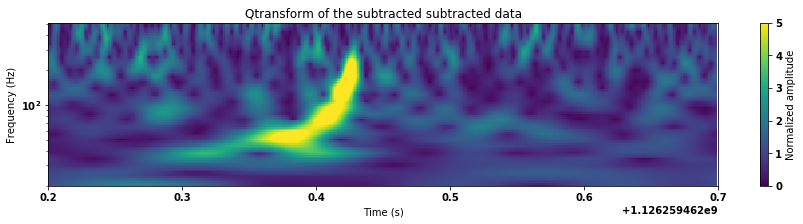

In [27]:
dt = tmaxS10 - subF10.start_time
inj = hmaxS10.cyclic_time_shift(dt)

#scale tempplate

inj /= sigma(hmaxS10, psd = psd10, low_frequency_cutoff = 20.)
inj *= maxsnrS10

subsubF10 = subF10 - inj

#whiten 

subsub_white10 = (subsubF10/psdS10**0.5).to_timeseries()
zoom = subsub_white10.time_slice(merger.time -0.2, merger.time + 0.3)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))

plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 0.2, merger.time + 0.3)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [28]:
#make the template that has been found above 
hpS10, _ = get_td_waveform(approximant = 'SEOBNRv4_opt', 
                           mass1 = m1maxS10, mass2 = m2maxS10,
                           distance = 440, delta_t = sub10.delta_t,
                              f_lower = f_low)

hpS10.resize(len(sub10))

In [29]:
#template of the event that can be subtracted out of the data

#freq
hp_f, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = 40.3, 
                         mass2 = 32.3, distance = 440, f_lower = 20., 
                                delta_f = strainF.delta_f)
hp_f.resize(len(strainF))
hp_f.start_time = strainF.start_time

#time
hp_t, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 40.3, 
                         mass2 = 32.3, distance = 440, f_lower = 20., 
                         delta_t = strain.delta_t)
hp_t.resize(len(strain))

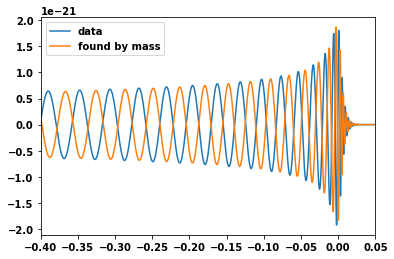

In [30]:
plt.plot(hp_t.sample_times, hp_t, label = 'data')
plt.plot(hpS10.sample_times, hpS10, label = 'found by mass')
plt.xlim(-0.4, 0.05)
plt.legend()

In this case, the direct ubtraction does not work anymore. However, an event is still found at the correct time (~0.01s). So, we can see if we can subtract it by using a best fit routine. If it is the case, we can argue that the event is still detected

Text(0.5,1,'Whitened data of GW150914 with the signal injected at 0.1s subtracted')

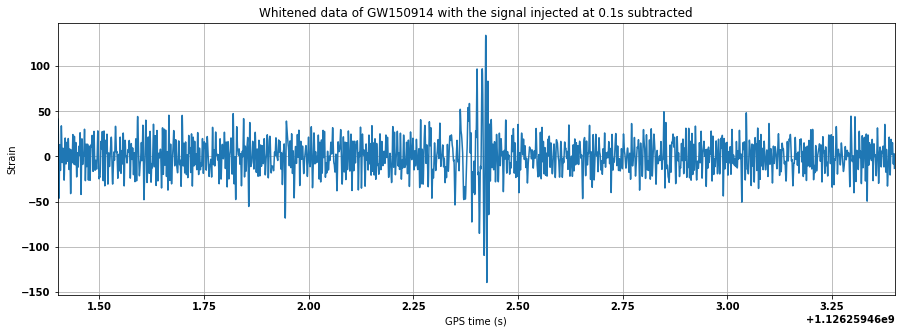

In [31]:
#whitening of the data
white_sigS10 =  (subF10/psdS10**0.5).to_timeseries()
white_sigS10 = white_sigS10.highpass_fir(30., 512).lowpass_fir(300, 512)
white_sigS10 = white_sigS10.time_slice(merger.time - 1, merger.time + 1)

plt.figure(figsize = [15, 5])
plt.plot(white_sigS10.sample_times, white_sigS10)
plt.xlim(merger.time - 1, merger.time + 1)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.grid()
plt.title("Whitened data of GW150914 with the signal injected at 0.1s subtracted")

In [32]:
def gen_template(theta, delta_t = sub10.delta_t, 
                 duration = sub10.duration, start_time = sub10.start_time,
                 f_lower = f_low):
    
    #unpack values used to adapt the template
    m1, m2, dist, time = theta
    
    #make the templayte with the values provided and adjust it to data
    hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1,
                            mass2 = m2, distance = dist, 
                             delta_t = delta_t, f_lower = f_low)
    
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - sub10.start_time)
    hp.start_time = sub10.start_time
    
    return hp

In [33]:
from pycbc.filter import get_cutoff_indices as get_ind

def loglikelihood(theta, df = subF10, f_lower = f_low, f_upper = f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t = df.delta_t, 
                            f_lower = f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = get_ind(f_lower, f_upper, df.delta_f,
                                          (N-1)*2)
    
    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj() * hf[kmin:kmax]).real()/psdS10[kmin:kmax])
    dh = sum (4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psdS10[kmin:kmax])
    
    logl = -0.5*(hh - 2.0*dh)
    
    return logl

In [34]:
def whiten_trim_template(template, psd = psdS10):
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd**0.5).to_timeseries()
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 10)
    
    return white_temp

def plot_white_strain(strain, template, zoom):
    white_data = (subF10/psdS10**0.5).to_timeseries()
    
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psdS10 **0.5).to_timeseries()
    
    white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data = white_data.time_slice(merger.time - 5, merger.time + 5)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 5)
    
    plt.figure(figsize = [15 , 3])
    plt.plot(white_data.sample_times, white_data, label = 'data')
    plt.plot(white_temp.sample_times, white_temp, label = 'template')
    plt.legend()
    plt.grid()
    plt.title("Superposition data and template")
    plt.ylabel("Strain")
    plt.xlabel("GPS time (s)")
    
    if zoom is True:
        plt.xlim(merger.time - 0.2, merger.time + 0.2)
    if zoom is False:
        plt.xlim(merger.time - 0.5, merger.time + 0.5)
        

-468.8032925583934


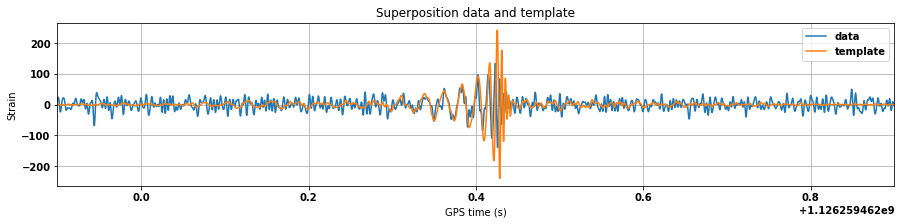

In [35]:
theta0 = [m1maxS10, m2maxS10, 440, tmaxS10]

temp0 = gen_template(theta0)
plot_white_strain(sub10, temp0, False)

print(loglikelihood(theta0))

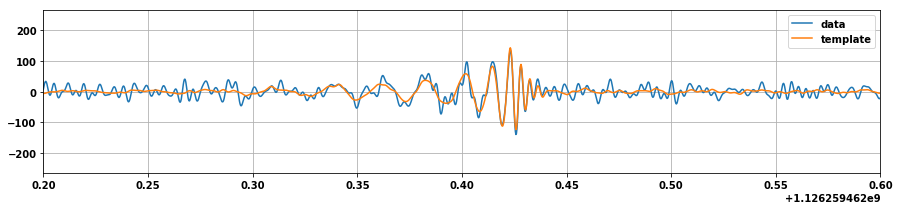

Steps 	 log(likelihood)
7 	 185.190


In [36]:
#best fit to adapt the found parameters to the signal
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize = [15, 3])
Neval = 1

white_temp = whiten_trim_template(gen_template(theta0))

plt.plot(white_sigS10.sample_times, white_sigS10, label = 'data')
line, = plt.plot(white_temp.sample_times, white_temp, label = 'template')

plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.grid()
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    temp = gen_template(thetai)
    white_temp = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_temp)
    
    clear_output(wait = True)
    display(fig)
    print("Steps \t log(likelihood)")
    print("%i \t %.3f" %(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta : -loglikelihood(theta), theta0, 
              callback = callback, method = 'powell')
plt.close()

[4.01765522e+01 3.15794558e+01 7.89134961e+02 1.12625946e+09]


Text(0.5,1,'Superposition of the whitened signal and the best fit template')

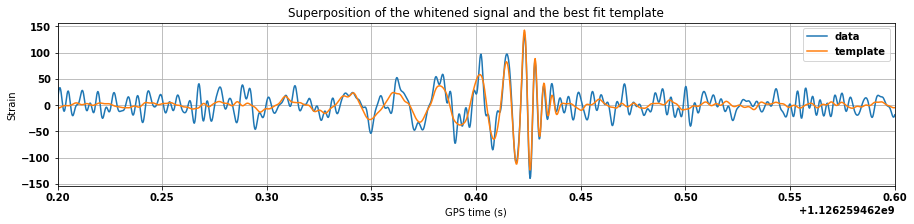

In [37]:
param = res.x
print(param)
best_fit_temp = gen_template(param)
plot_white_strain(sub10, best_fit_temp, True)
plt.title("Superposition of the whitened signal and the best fit template")

Text(0,0.5,'Normalized amplitude')

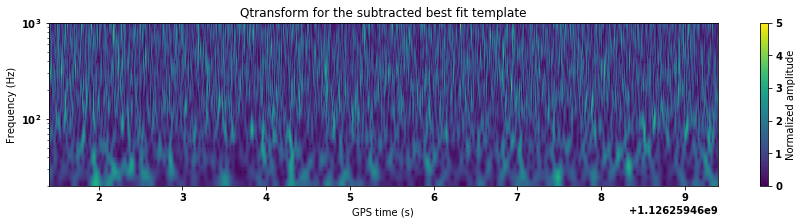

In [38]:
subsub10 = sub10 - best_fit_temp

t, f, p = subsub10.whiten(1,1).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted best fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 1, merger.time + 7)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

Although we needed to do a best fit in order to subtract the signal correctly, we can still find the second event with parameters that are in the error margins of the GWTc1 catalog. So, we could say that at 0.1 second, the event can still be found

## For 0.05 s

Here the overlap should be even more important

In [39]:
merger = Merger("GW150914")
strain = merger.strain("H1")
strain = highpass(strain, 15)
strain = strain.crop(2,2)

strainF = strain.to_frequencyseries()

In [40]:
# making the signal with the injection at 0.05 sec
time_shifts = np.arange(5, 20, 0.01)

model_inj = None
max_amp_inj, time_inj, time_dif = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 40.3, 
                              mass2 = 32.3, distance = 440, f_lower = 20.,
                              delta_t = strain.delta_t)
    hpInj.resize(len(strain))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strain.start_time
    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_ev = hpInj.sample_times[ind]
    time_diff = time_ev - merger.time
    if (abs(time_diff - 0.05) < 0.01):
        model_inj = hpInj
        max_amp_inj, time_inj, time_dif_inj = max_amp, time_ev, time_diff


In [41]:
print(model_inj)
print(time_dif_inj)

[-3.11987655e-28  3.12055221e-28 -3.12122793e-28 ...  3.11784949e-28
 -3.11852518e-28  3.11920084e-28]
0.05849599838256836


In [42]:
#infos about the injection
print("Max amplitude: ", max_amp_inj)
print("time of the merger for the injection: ", time_inj)
print("Time gap between merger and injection: ", time_dif_inj)

('Max amplitude: ', 1.82391062292214e-21)
('time of the merger for the injection: ', 1126259462.458496)
('Time gap between merger and injection: ', 0.05849599838256836)


In [44]:
sig05 = strain + model_inj

sigF05 = sig05.to_frequencyseries()

p05 = sig05.psd(2)
p05 = interpolate(p05, sig05.delta_f)
psd05 = inverse_spectrum_truncation(p05, 2*sig05.sample_rate, 
                                 low_frequency_cutoff = 20.)

Text(0,0.5,'Normalized amplitude')

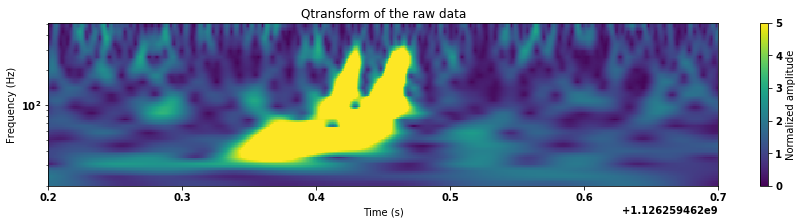

In [45]:
# qtransform of the data to see what it looks like

zoom = sig05.whiten(2,2).time_slice(merger.time - 1, merger.time + 1)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange = (20,512),
                             qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 0.2, merger.time + 0.3)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [47]:
#try to detect one event
import numpy as np

mass1 = np.arange(32.5, 40.4, 0.1)
mass2 = np.arange(29.7, 32.4, 0.1)

hmax05 = None
maxsnr05, m1max05, m2max05, tmax05 = 0, 0, 0, 0

snrs05 = [[] for i in range(len(mass1))]
max_snrs05 = [[] for i in range(len(mass1))]
times_max05 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF05.delta_f)
        hp.resize(len(sigF05))
        
        snr = matched_filter(hp, sigF05, psd = psd05, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 5, merger.time + 5)
        snrs05[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs05[i].append(snrp)
        time = snr.sample_times[idx]
        times_max05[i].append(time)
        
        # Keep track of the max snr
        
        if snrp > maxsnr05:
            tmax05, hmax05, m1max05, m2max05, maxsnr05 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1max05, m2max05, tmax05, maxsnr05))
print(time_inj)

mass 1 1/79
Done
mass 1 2/79
Done
mass 1 3/79
Done
mass 1 4/79
Done
mass 1 5/79
Done
mass 1 6/79
Done
mass 1 7/79
Done
mass 1 8/79
Done
mass 1 9/79
Done
mass 1 10/79
Done
mass 1 11/79
Done
mass 1 12/79
Done
mass 1 13/79
Done
mass 1 14/79
Done
mass 1 15/79
Done
mass 1 16/79
Done
mass 1 17/79
Done
mass 1 18/79
Done
mass 1 19/79
Done
mass 1 20/79
Done
mass 1 21/79
Done
mass 1 22/79
Done
mass 1 23/79
Done
mass 1 24/79
Done
mass 1 25/79
Done
mass 1 26/79
Done
mass 1 27/79
Done
mass 1 28/79
Done
mass 1 29/79
Done
mass 1 30/79
Done
mass 1 31/79
Done
mass 1 32/79
Done
mass 1 33/79
Done
mass 1 34/79
Done
mass 1 35/79
Done
mass 1 36/79
Done
mass 1 37/79
Done
mass 1 38/79
Done
mass 1 39/79
Done
mass 1 40/79
Done
mass 1 41/79
Done
mass 1 42/79
Done
mass 1 43/79
Done
mass 1 44/79
Done
mass 1 45/79
Done
mass 1 46/79
Done
mass 1 47/79
Done
mass 1 48/79
Done
mass 1 49/79
Done
mass 1 50/79
Done
mass 1 51/79
Done
mass 1 52/79
Done
mass 1 53/79
Done
mass 1 54/79
Done
mass 1 55/79
Done
mass 1 56/79
Done
m

In [48]:
print(merger.time)

1126259462.4


Text(0,0.5,'Normalized amplitude')

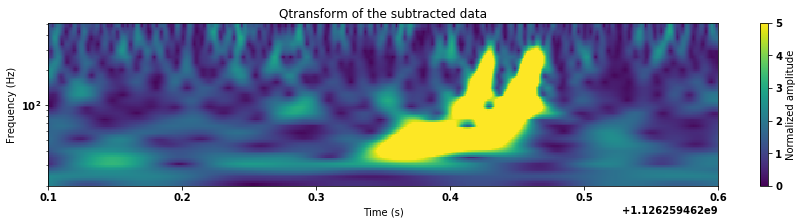

In [51]:
t = tmax05 - sigF05.start_time
inj = hmax05.cyclic_time_shift(dt)

#scaling of the template 
inj /= sigma(hmax05, psd = psd05, low_frequency_cutoff = 20.)
inj *= maxsnr05

#subtraction
subF = sigF05 - inj

#whiten
subT_white05 = (sigF05/psd05**0.5).to_timeseries()
zoom = subT_white05.time_slice(merger.time - 1, merger.time + 1)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 0.3, merger.time + 0.2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [52]:
f_low = 20.
f_upper = 1024.

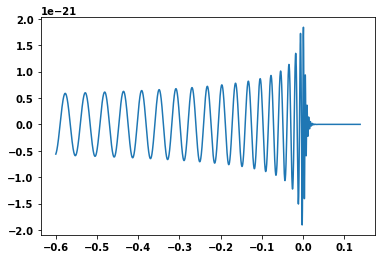

In [54]:
hp_st05, hf_st05 = get_td_waveform(approximant = "SEOBNRv4_opt", 
                                   mass1 = m1max05, mass2 = m2max05, 
                                   distance = 440, 
                                   delta_t = sig05.delta_t,
                              f_lower = f_low)
plt.plot(hp_st05.sample_times, hp_st05)

Text(0.5,1,'Whitened data of GW150914 with the signal injected at 5 s')

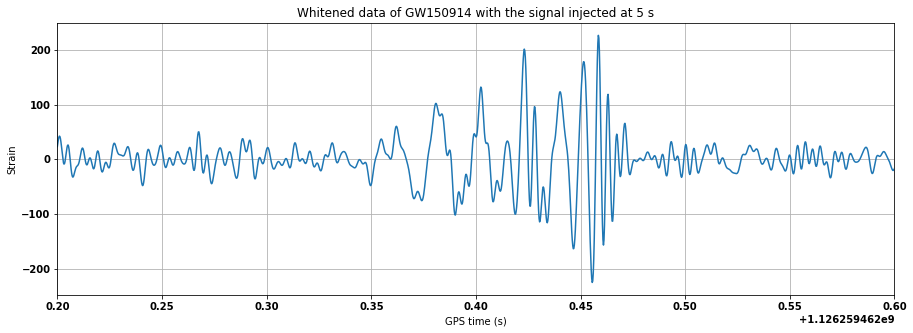

In [56]:
#whitening of the data
white_sig05 =  (sigF05/psd05**0.5).to_timeseries()
white_sig05 = white_sig05.highpass_fir(30., 512).lowpass_fir(300, 512)
white_sig05 = white_sig05.time_slice(merger.time - 1, merger.time + 11)

plt.figure(figsize = [15, 5])
plt.plot(white_sig05.sample_times, white_sig05)
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.grid()
plt.title("Whitened data of GW150914 with the signal injected at 5 s")

In [57]:
def gen_template(theta, delta_t = sig05.delta_t, 
                 duration = sig05.duration, start_time = sig05.start_time,
                 f_lower = f_low):
    
    #unpack values used to adapt the template
    m1, m2, dist, time = theta
    
    #make the templayte with the values provided and adjust it to data
    hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1,
                            mass2 = m2, distance = dist, 
                             delta_t = delta_t, f_lower = f_low)
    
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - sig05.start_time)
    hp.start_time = sig05.start_time
    
    return hp

In [58]:
from pycbc.filter import get_cutoff_indices as get_ind

def loglikelihood(theta, df = sigF05, f_lower = f_low, f_upper = f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t = df.delta_t, 
                            f_lower = f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = get_ind(f_lower, f_upper, df.delta_f,
                                          (N-1)*2)
    
    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj() * hf[kmin:kmax]).real()/psd05[kmin:kmax])
    dh = sum (4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd05[kmin:kmax])
    
    logl = -0.5*(hh - 2.0*dh)
    
    return logl

In [59]:
def whiten_trim_template(template, psd = psd05):
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd05**0.5).to_timeseries()
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    white_temp = white_temp.time_slice(merger.time - 1, merger.time + 1)
    
    return white_temp

def plot_white_strain(strain, template, zoom):
    white_data = (sigF05/psd05**0.5).to_timeseries()
    
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd05 **0.5).to_timeseries()
    
    white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data = white_data.time_slice(merger.time - 1, merger.time + 1)
    white_temp = white_temp.time_slice(merger.time - 1, merger.time + 1)
    
    plt.figure(figsize = [15 , 3])
    plt.plot(white_data.sample_times, white_data, label = 'data')
    plt.plot(white_temp.sample_times, white_temp, label = 'template')
    plt.legend()
    plt.grid()
    plt.title("Superposition data and template")
    plt.ylabel("Strain")
    plt.xlabel("GPS time (s)")
    
    if zoom is True:
        plt.xlim(merger.time - 0.2, merger.time + .3)
    if zoom is False:
        plt.xlim(merger.time - 0.3, merger.time + .5)
        

-728.2054022365855


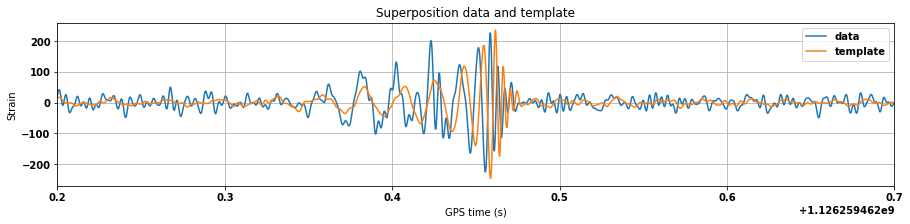

In [60]:
theta0 = [m1max05, m2max05, 440, tmax05]

temp0 = gen_template(theta0)
plot_white_strain(sig05, temp0, True)

print(loglikelihood(theta0))

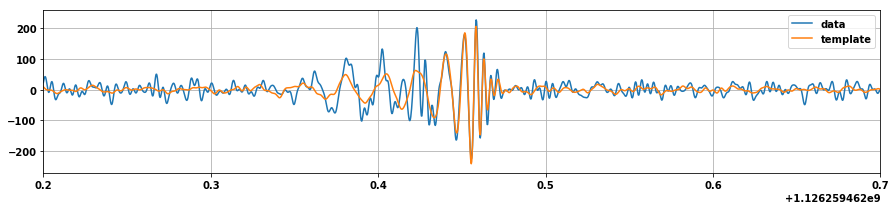

Steps 	 log(likelihood)
8 	 536.032


In [61]:
#best fit to adapt the found parameters to the signal
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize = [15, 3])
Neval = 1

white_temp = whiten_trim_template(gen_template(theta0))

plt.plot(white_sig05.sample_times, white_sig05, label = 'data')
line, = plt.plot(white_temp.sample_times, white_temp, label = 'template')

plt.xlim(merger.time - 0.2, merger.time + 0.3)
plt.grid()
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    temp = gen_template(thetai)
    white_temp = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_temp)
    
    clear_output(wait = True)
    display(fig)
    print("Steps \t log(likelihood)")
    print("%i \t %.3f" %(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta : -loglikelihood(theta), theta0, 
              callback = callback, method = 'powell')
plt.close()

[4.27797355e+01 3.24119317e+01 4.79666281e+02 1.12625946e+09]


Text(0.5,1,'Whitened signal with best fit template superposed')

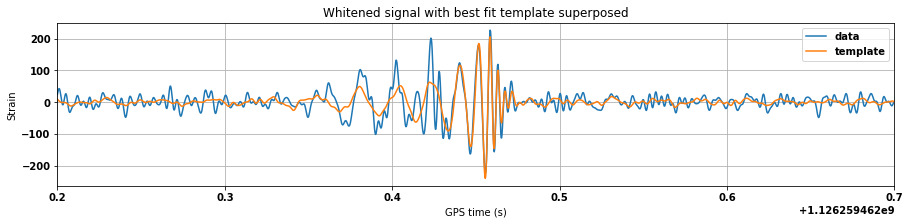

In [62]:
para05 = res.x
print(para05)
best_temp05 = gen_template(para05)
plot_white_strain(sig05, best_temp05, True)
plt.title("Whitened signal with best fit template superposed")

Text(0,0.5,'Normalized amplitude')

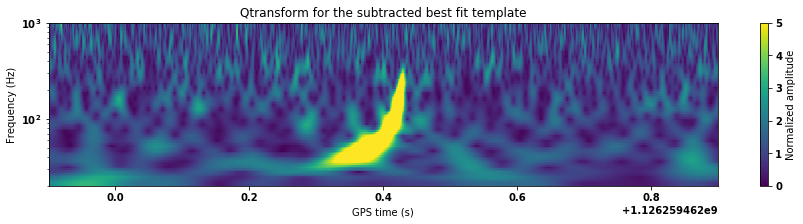

In [64]:
#subtraction
subtracted05 = sig05 - best_temp05

t, f, p = subtracted05.whiten(4,4).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted best fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 0.5, merger.time +.5)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [65]:
#psd of the subtracted data
pp05 = subtracted05.psd(2)
pp05 = interpolate(pp05, subtracted05.delta_f)
psd_s05 = inverse_spectrum_truncation(pp05, 2*subtracted05.sample_rate, 
                                  low_frequency_cutoff = 15.,
                                  trunc_method = 'hann')


In [66]:
#subtracted signal in the frequency domain
subF05 = subtracted05.to_frequencyseries()

In [67]:
#matched filtering for the event

mass1 = np.arange(32.5, 40.4, 0.1)
mass2 = np.arange(29.1, 32.4, 0.1)

hmaxS05 = None
maxsnrS05, m1maxS05, m2maxS05, tmaxS05 = 0, 0, 0, 0

snrsS05 = [[] for i in range(len(mass1))]
max_snrsS05 = [[] for i in range(len(mass1))]
time_maxS05 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass 1: %i/%i" %(i+1,len(mass1)))
    for m2 in mass2:
        #template generation
        hp, _ = get_fd_waveform(approximant = 'IMRPhenomD', mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20.,
                               delta_f = subF05.delta_f)
        hp.resize(len(subF05))
        
        #matched filtering
        snr = matched_filter(hp, subF05, psd = psd_s05, 
                             low_frequency_cutoff = 20.)
        snr = snr.time_slice(merger.time - 10, merger.time + 10)
        snrsS05[i].append(snr)
        ind = abs(snr).numpy().argmax()
        snrp = abs(snr[ind])
        max_snrsS05[i].append(snrp)
        time = snr.sample_times[ind]
        time_maxS05[i].append(time)
        
        #keep track of max snr
        
        if snrp > maxsnrS05:
            tmaxS05, hmaxS05, m1maxS05, m2maxS05, maxsnrS05 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.2f and m2 = %.2f at time %.7f with a value of %.7f" %(m1maxS05, m2maxS05, tmaxS05, maxsnrS05))

Mass 1: 1/79
Done
Mass 1: 2/79
Done
Mass 1: 3/79
Done
Mass 1: 4/79
Done
Mass 1: 5/79
Done
Mass 1: 6/79
Done
Mass 1: 7/79
Done
Mass 1: 8/79
Done
Mass 1: 9/79
Done
Mass 1: 10/79
Done
Mass 1: 11/79
Done
Mass 1: 12/79
Done
Mass 1: 13/79
Done
Mass 1: 14/79
Done
Mass 1: 15/79
Done
Mass 1: 16/79
Done
Mass 1: 17/79
Done
Mass 1: 18/79
Done
Mass 1: 19/79
Done
Mass 1: 20/79
Done
Mass 1: 21/79
Done
Mass 1: 22/79
Done
Mass 1: 23/79
Done
Mass 1: 24/79
Done
Mass 1: 25/79
Done
Mass 1: 26/79
Done
Mass 1: 27/79
Done
Mass 1: 28/79
Done
Mass 1: 29/79
Done
Mass 1: 30/79
Done
Mass 1: 31/79
Done
Mass 1: 32/79
Done
Mass 1: 33/79
Done
Mass 1: 34/79
Done
Mass 1: 35/79
Done
Mass 1: 36/79
Done
Mass 1: 37/79
Done
Mass 1: 38/79
Done
Mass 1: 39/79
Done
Mass 1: 40/79
Done
Mass 1: 41/79
Done
Mass 1: 42/79
Done
Mass 1: 43/79
Done
Mass 1: 44/79
Done
Mass 1: 45/79
Done
Mass 1: 46/79
Done
Mass 1: 47/79
Done
Mass 1: 48/79
Done
Mass 1: 49/79
Done
Mass 1: 50/79
Done
Mass 1: 51/79
Done
Mass 1: 52/79
Done
Mass 1: 53/79
Done
Ma

In [68]:
print(merger.time)

1126259462.4


Text(0,0.5,'Normalized amplitude')

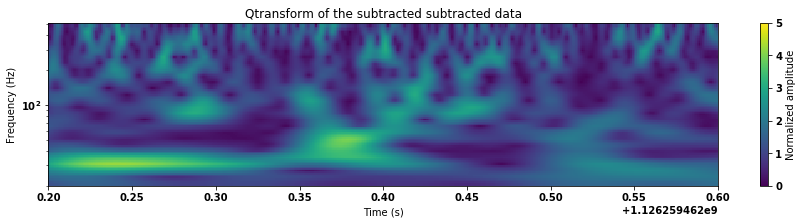

In [69]:
#trial of subtraction
dt = tmaxS05 - subF05.start_time
inj = hmaxS05.cyclic_time_shift(dt)

#scale tempplate

inj /= sigma(hmaxS05, psd = psd_s05, low_frequency_cutoff = 20.)
inj *= maxsnrS05

subsubF05 = subF05 - inj

#whiten 

subsub_white05 = (subsubF05/psd_s05**0.5).to_timeseries()
zoom = subsub_white05.time_slice(merger.time -1, merger.time + 1)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))

plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

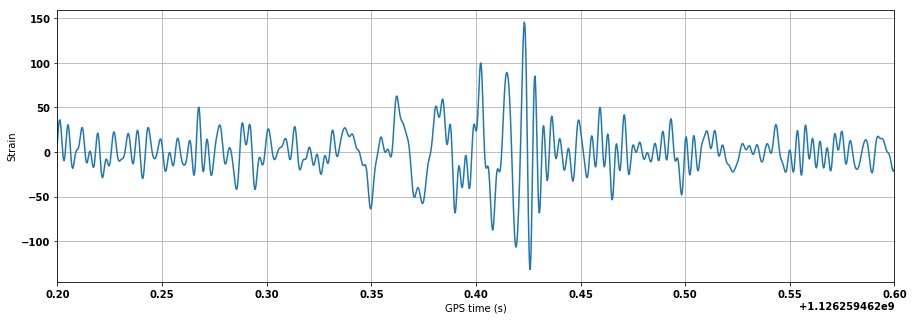

In [77]:
#whitening of the data
white_sigS05 =  (subF05/psd_s05**0.5).to_timeseries()
white_sigS05 = white_sigS05.highpass_fir(30., 512).lowpass_fir(300, 512)
white_sigS05 = white_sigS05.time_slice(merger.time - 5, merger.time + 10)

plt.figure(figsize = [15, 5])
plt.plot(white_sigS05.sample_times, white_sigS05)
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.grid()

The subraction is not bad. Still, we will do a best fit system in order to see if we can find the correct signal at the end with reasonable parameters

In [78]:
def gen_template(theta, delta_t = subtracted05.delta_t, 
                 duration = subtracted05.duration, start_time = subtracted05.start_time,
                 f_lower = f_low):
    
    #unpack values used to adapt the template
    m1, m2, dist, time = theta
    
    #make the templayte with the values provided and adjust it to data
    hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1,
                            mass2 = m2, distance = dist, 
                             delta_t = delta_t, f_lower = f_low)
    
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - subtracted05.start_time)
    hp.start_time =subtracted05.start_time
    
    return hp

In [79]:
from pycbc.filter import get_cutoff_indices as get_ind
def loglikelihood(theta, df = sigF05, f_lower = f_low, f_upper = f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t = df.delta_t, 
                            f_lower = f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = get_ind(f_lower, f_upper, df.delta_f,
                                          (N-1)*2)
    
    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj() * hf[kmin:kmax]).real()/psd_s05[kmin:kmax])
    dh = sum (4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd_s05[kmin:kmax])
    
    logl = -0.5*(hh - 2.0*dh)
    
    return logl

In [80]:
def whiten_trim_template(template, psd = psd_s05):
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd**0.5).to_timeseries()
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 5)
    
    return white_temp

def plot_white_strain(strain, template, zoom):
    white_data = (sigF05/psd_s05**0.5).to_timeseries()
    
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd_s05 **0.5).to_timeseries()
    
    white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data = white_data.time_slice(merger.time - 5, merger.time + 5)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 5)
    
    plt.figure(figsize = [15 , 3])
    plt.plot(white_data.sample_times, white_data, label = 'data')
    plt.plot(white_temp.sample_times, white_temp, label = 'template')
    plt.legend()
    plt.grid()
    plt.title("Superposition data and template")
    plt.ylabel("Strain")
    plt.xlabel("GPS time (s)")
    
    if zoom is True:
        plt.xlim(merger.time - 0.2, merger.time + 0.2)
    if zoom is False:
        plt.xlim(merger.time - 0.3, merger.time + 0.5)
        

-828.1554771642514


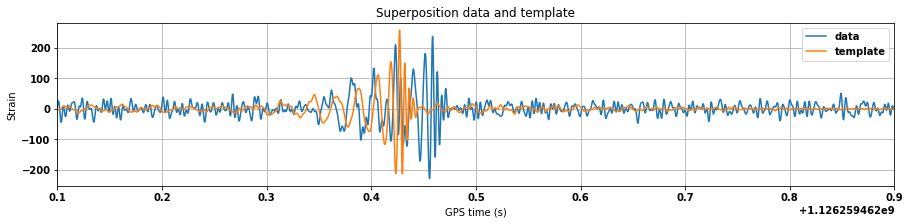

In [81]:
theta0 = [m1maxS05, m2maxS05, 440, tmaxS05]

temp0 = gen_template(theta0)
plot_white_strain(subtracted05, temp0, False)

print(loglikelihood(theta0))

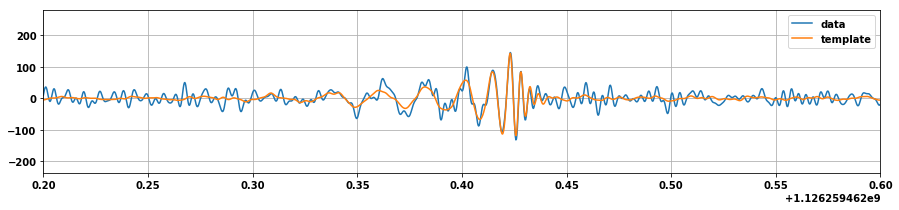

Steps 	 log(likelihood)
9 	 183.884


In [83]:
#best fit to adapt the found parameters to the signal
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize = [15, 3])
Neval = 1

white_temp = whiten_trim_template(gen_template(theta0))

plt.plot(white_sigS05.sample_times, white_sigS05, label = 'data')
line, = plt.plot(white_temp.sample_times, white_temp, label = 'template')

plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.grid()
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    temp = gen_template(thetai)
    white_temp = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_temp)
    
    clear_output(wait = True)
    display(fig)
    print("Steps \t log(likelihood)")
    print("%i \t %.3f" %(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta : -loglikelihood(theta), theta0, 
              callback = callback, method = 'powell')
plt.close()

[4.15893600e+01 3.24569618e+01 8.16026978e+02 1.12625946e+09]


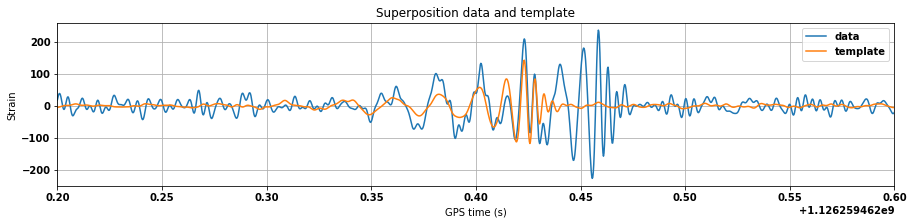

In [84]:
paraS05 = res.x
print(paraS05)
best_tempS05 = gen_template(paraS05)
plot_white_strain(subtracted05, best_tempS05, True)

Text(0,0.5,'Normalized amplitude')

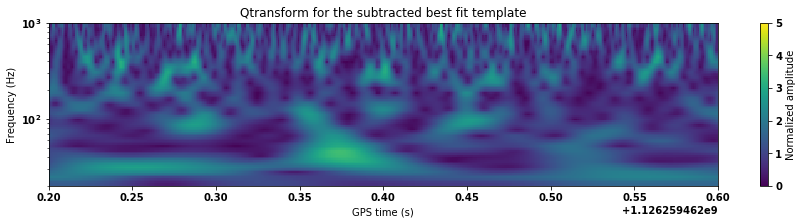

In [87]:
subsub05 = subtracted05 - best_tempS05

t, f, p = subsub05.whiten(4,4).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted best fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - .2, merger.time + 0.2)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

At the end, the subtractuion is still relatively well done and the paraemters that are foud are not absurd

## For 0.02s

Here the superposition will be even more important

In [3]:
merger = Merger("GW150914")
strain = merger.strain("H1")
strain = highpass(strain, 15)
strain = strain.crop(2,2)

strainF = strain.to_frequencyseries()

In [4]:
# making the signal with the injection at 0.02 sec
time_shifts = np.arange(5, 20, 0.01)

model_inj = None
max_amp_inj, time_inj, time_dif = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 40.3, 
                              mass2 = 32.3, distance = 440, f_lower = 20.,
                              delta_t = strain.delta_t)
    hpInj.resize(len(strain))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strain.start_time
    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_ev = hpInj.sample_times[ind]
    time_diff = time_ev - merger.time
    if (abs(time_diff - 0.02) < 0.01):
        model_inj = hpInj
        max_amp_inj, time_inj, time_dif_inj = max_amp, time_ev, time_diff


In [5]:
print(model_inj)
print(time_dif_inj)

[ 2.75309766e-28 -2.75367894e-28  2.75426027e-28 ... -2.75135377e-28
  2.75193508e-28 -2.75251635e-28]
0.02846670150756836


In [6]:
#infos about the injection
print("Max amplitude: ", max_amp_inj)
print("time of the merger for the injection: ", time_inj)
print("Time gap between merger and injection: ", time_dif_inj)

('Max amplitude: ', 1.820726655022926e-21)
('time of the merger for the injection: ', 1126259462.4284668)
('Time gap between merger and injection: ', 0.02846670150756836)


In [7]:
#now we add the injection in the strain 

sig02 = strain + model_inj

sigF02 = sig02.to_frequencyseries()

p0 = sig02.psd(2)
p0 = interpolate(p0, sig02.delta_f)
psd02 = inverse_spectrum_truncation(p0, 2*sig02.sample_rate, 
                                 low_frequency_cutoff = 20.)

/home/justin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0,0.5,'Normalized amplitude')

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


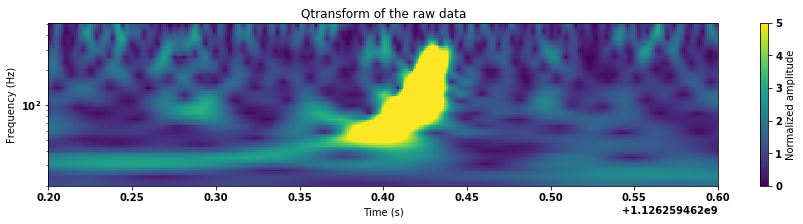

In [8]:
zoom = sig02.whiten(2,2).time_slice(merger.time - 1, merger.time + 1)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange = (20,512),
                             qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [9]:
import numpy as np

mass1 = np.arange(32.5, 40.4, 0.1)
mass2 = np.arange(29.7, 32.4, 0.1)

hmax02 = None
maxsnr02, m1max02, m2max02, tmax02 = 0, 0, 0, 0

snrs02 = [[] for i in range(len(mass1))]
max_snrs02 = [[] for i in range(len(mass1))]
times_max02 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF02.delta_f)
        hp.resize(len(sigF02))
        
        snr = matched_filter(hp, sigF02, psd = psd02, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 5, merger.time + 5)
        snrs02[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs02[i].append(snrp)
        time = snr.sample_times[idx]
        times_max02[i].append(time)
        
        # Keep track of the max snr
        
        if snrp > maxsnr02:
            tmax02, hmax02, m1max02, m2max02, maxsnr02 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1max02, m2max02, tmax02, maxsnr02))
print(time_inj)

mass 1 1/79
Done
mass 1 2/79
Done
mass 1 3/79
Done
mass 1 4/79
Done
mass 1 5/79
Done
mass 1 6/79
Done
mass 1 7/79
Done
mass 1 8/79
Done
mass 1 9/79
Done
mass 1 10/79
Done
mass 1 11/79
Done
mass 1 12/79
Done
mass 1 13/79
Done
mass 1 14/79
Done
mass 1 15/79
Done
mass 1 16/79
Done
mass 1 17/79
Done
mass 1 18/79
Done
mass 1 19/79
Done
mass 1 20/79
Done
mass 1 21/79
Done
mass 1 22/79
Done
mass 1 23/79
Done
mass 1 24/79
Done
mass 1 25/79
Done
mass 1 26/79
Done
mass 1 27/79
Done
mass 1 28/79
Done
mass 1 29/79
Done
mass 1 30/79
Done
mass 1 31/79
Done
mass 1 32/79
Done
mass 1 33/79
Done
mass 1 34/79
Done
mass 1 35/79
Done
mass 1 36/79
Done
mass 1 37/79
Done
mass 1 38/79
Done
mass 1 39/79
Done
mass 1 40/79
Done
mass 1 41/79
Done
mass 1 42/79
Done
mass 1 43/79
Done
mass 1 44/79
Done
mass 1 45/79
Done
mass 1 46/79
Done
mass 1 47/79
Done
mass 1 48/79
Done
mass 1 49/79
Done
mass 1 50/79
Done
mass 1 51/79
Done
mass 1 52/79
Done
mass 1 53/79
Done
mass 1 54/79
Done
mass 1 55/79
Done
mass 1 56/79
Done
m

In [10]:
import numpy as np

mass1 = np.arange(40., 50.1, 0.1)
mass2 = np.arange(35, 45.1, 0.1)

hmax02B = None
maxsnr02B, m1max02B, m2max02B, tmax02B = 0, 0, 0, 0

snrs02B = [[] for i in range(len(mass1))]
max_snrs02B = [[] for i in range(len(mass1))]
times_max02B = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF02.delta_f)
        hp.resize(len(sigF02))
        
        snr = matched_filter(hp, sigF02, psd = psd02, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 5, merger.time + 5)
        snrs02B[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs02B[i].append(snrp)
        time = snr.sample_times[idx]
        times_max02B[i].append(time)
        
        # Keep track of the max snr
        
        if snrp > maxsnr02B:
            tmax02B, hmax02B, m1max02B, m2max02B, maxsnr02B = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1max02B, m2max02B, tmax02B, maxsnr02B))
print(time_inj)

mass 1 1/102
Done
mass 1 2/102
Done
mass 1 3/102
Done
mass 1 4/102
Done
mass 1 5/102
Done
mass 1 6/102
Done
mass 1 7/102
Done
mass 1 8/102
Done
mass 1 9/102
Done
mass 1 10/102
Done
mass 1 11/102
Done
mass 1 12/102
Done
mass 1 13/102
Done
mass 1 14/102
Done
mass 1 15/102
Done
mass 1 16/102
Done
mass 1 17/102
Done
mass 1 18/102
Done
mass 1 19/102
Done
mass 1 20/102
Done
mass 1 21/102
Done
mass 1 22/102
Done
mass 1 23/102
Done
mass 1 24/102
Done
mass 1 25/102
Done
mass 1 26/102
Done
mass 1 27/102
Done
mass 1 28/102
Done
mass 1 29/102
Done
mass 1 30/102
Done
mass 1 31/102
Done
mass 1 32/102
Done
mass 1 33/102
Done
mass 1 34/102
Done
mass 1 35/102
Done
mass 1 36/102
Done
mass 1 37/102
Done
mass 1 38/102
Done
mass 1 39/102
Done
mass 1 40/102
Done
mass 1 41/102
Done
mass 1 42/102
Done
mass 1 43/102
Done
mass 1 44/102
Done
mass 1 45/102
Done
mass 1 46/102
Done
mass 1 47/102
Done
mass 1 48/102
Done
mass 1 49/102
Done
mass 1 50/102
Done
mass 1 51/102
Done
mass 1 52/102
Done
mass 1 53/102
Done
ma

Text(0,0.5,'Normalized amplitude')

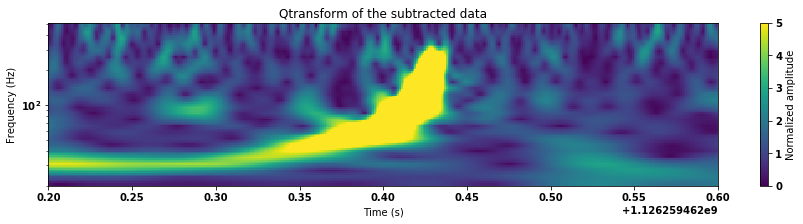

In [11]:
#try to subract with the first results

#subtraction of the signal to see if it works

dt = tmax02B - sigF02.start_time
inj = hmax02B.cyclic_time_shift(dt)

#scaling of the template 
inj /= sigma(hmax02B, psd = psd02, low_frequency_cutoff = 20.)
inj *= maxsnr02B

#subtraction
subF02B = sigF02 - inj

#whiten
subT_white02B = (subF02B/psd02**0.5).to_timeseries()
zoom = subT_white02B.time_slice(merger.time - 1, merger.time + 1)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [12]:
f_low = 20.
f_upper = 1024.

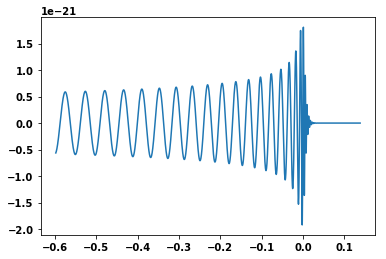

In [13]:
#strting model that wil be adjusted:

hp_st02, hf_st02 = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1max02,
                              mass2 = m2max02, distance = 440, delta_t = sig02.delta_t,
                              f_lower = f_low)
plt.plot(hp_st02.sample_times, hp_st02)

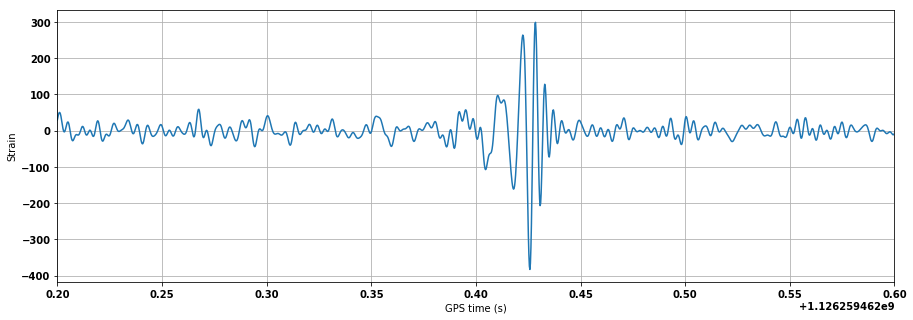

In [14]:
#whitening of the data
white_sig02 =  (sigF02/psd02**0.5).to_timeseries()
white_sig02 = white_sig02.highpass_fir(30., 512).lowpass_fir(300, 512)
white_sig02 = white_sig02.time_slice(merger.time - 5, merger.time + 5)

plt.figure(figsize = [15, 5])
plt.plot(white_sig02.sample_times, white_sig02)
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.grid()

In [15]:
def gen_template(theta, delta_t = sig02.delta_t, 
                 duration = sig02.duration, start_time = sig02.start_time,
                 f_lower = f_low):
    
    #unpack values used to adapt the template
    m1, m2, dist, time = theta
    
    #make the templayte with the values provided and adjust it to data
    hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1,
                            mass2 = m2, distance = dist, 
                             delta_t = delta_t, f_lower = f_low)
    
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - sig02.start_time)
    hp.start_time = sig02.start_time
    
    return hp

In [16]:
from pycbc.filter import get_cutoff_indices as get_ind

def loglikelihood(theta, df = sigF02, f_lower = f_low, f_upper = f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t = df.delta_t, 
                            f_lower = f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = get_ind(f_lower, f_upper, df.delta_f,
                                          (N-1)*2)
    
    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj() * hf[kmin:kmax]).real()/psd02[kmin:kmax])
    dh = sum (4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd02[kmin:kmax])
    
    logl = -0.5*(hh - 2.0*dh)
    
    return logl

In [17]:
def whiten_trim_template(template, psd = psd02):
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd02**0.5).to_timeseries()
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 5)
    
    return white_temp

def plot_white_strain(strain, template, zoom):
    white_data = (sigF02/psd02**0.5).to_timeseries()
    
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd02 **0.5).to_timeseries()
    
    white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data = white_data.time_slice(merger.time - 5, merger.time + 5)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 5)
    
    plt.figure(figsize = [15 , 3])
    plt.plot(white_data.sample_times, white_data, label = 'data')
    plt.plot(white_temp.sample_times, white_temp, label = 'template')
    plt.legend()
    plt.grid()
    plt.title("Superposition data and template")
    plt.ylabel("Strain")
    plt.xlabel("GPS time (s)")
    
    if zoom is True:
        plt.xlim(merger.time - 0.2, merger.time + 0.2)
    if zoom is False:
        plt.xlim(merger.time - 0.5, merger.time + 0.5)
        

-678.466831803335


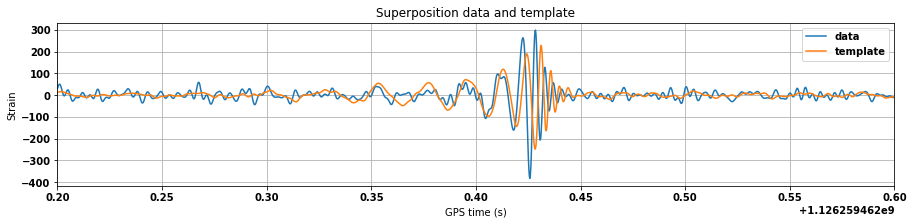

In [18]:
theta0 = [m1max02, m2max02, 440, tmax02]

temp0 = gen_template(theta0)
plot_white_strain(sig02, temp0, True)

print(loglikelihood(theta0))

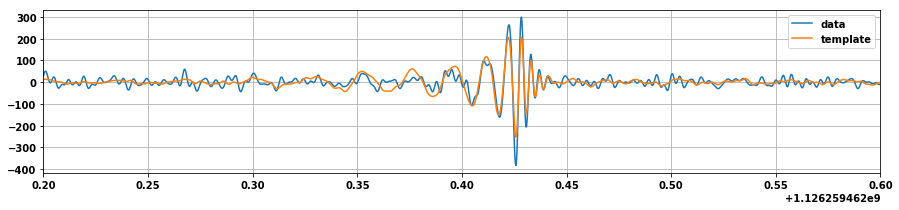

Steps 	 log(likelihood)
7 	 597.217


In [19]:
#best fit to adapt the found parameters to the signal
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize = [15, 3])
Neval = 1

white_temp = whiten_trim_template(gen_template(theta0))

plt.plot(white_sig02.sample_times, white_sig02, label = 'data')
line, = plt.plot(white_temp.sample_times, white_temp, label = 'template')

plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.grid()
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    temp = gen_template(thetai)
    white_temp = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_temp)
    
    clear_output(wait = True)
    display(fig)
    print("Steps \t log(likelihood)")
    print("%i \t %.3f" %(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta : -loglikelihood(theta), theta0, 
              callback = callback, method = 'powell')
plt.close()

[4.06298329e+01 3.23231272e+01 4.45302404e+02 1.12625946e+09]


Text(0.5,1,'Superposition sugnal and best fit template')

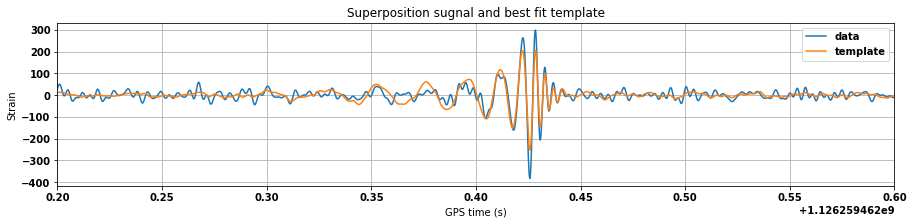

In [20]:
para02 = res.x
print(para02)
best_temp02 = gen_template(para02)
plot_white_strain(sig02, best_temp02, True)
plt.title("Superposition sugnal and best fit template")

Text(0,0.5,'Normalized amplitude')

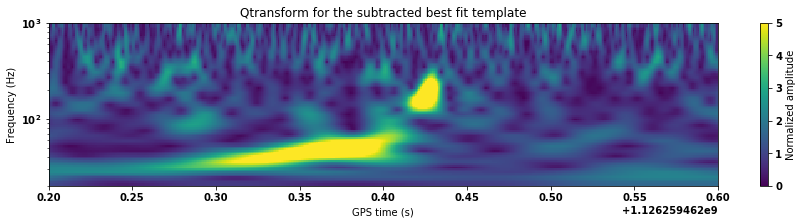

In [21]:
#subtraction

#try to subtract the best fit template to see if it works

sub02 = sig02 - best_temp02

t, f, p = sub02.whiten(4,4).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted best fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

theta0B = [m1max02B, m2max02B, 440, tmax02B]

temp0B = gen_template(theta0B)
plot_white_strain(sig02, temp0B, True)

print(loglikelihood(theta0))

#best fit to adapt the found parameters to the signal
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize = [15, 3])
Neval = 1

white_temp = whiten_trim_template(gen_template(theta0))

plt.plot(white_sig02.sample_times, white_sig02, label = 'data')
line, = plt.plot(white_temp.sample_times, white_temp, label = 'template')

plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.grid()
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    temp = gen_template(thetai)
    white_temp = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_temp)
    
    clear_output(wait = True)
    display(fig)
    print("Steps \t log(likelihood)")
    print("%i \t %.3f" %(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta : -loglikelihood(theta), theta0B, 
              callback = callback, method = 'powell')
plt.close()

para02B = res.x
print(para02B)
best_temp02B = gen_template(para02B)
plot_white_strain(sig02, best_temp02, True)
plt.title("Superposition sugnal and best fit template")

#try to subtract the best fit template to see if it works

sub02B = sig02 - best_temp02B

t, f, p = sub02B.whiten(4,4).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted best fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [22]:
#psd of the subtracted data
pS2 = sub02.psd(2)
pS2 = interpolate(pS2, sub02.delta_f)
psdS2 = inverse_spectrum_truncation(pS2, 2*sub02.sample_rate, 
                                  low_frequency_cutoff = 15.,
                                  trunc_method = 'hann')


In [23]:
#subtracted signal in the frequency domain
subF02 = sub02.to_frequencyseries()

In [24]:
#matched filtering for the event

mass1 = np.arange(32.5, 40.4, 0.1)
mass2 = np.arange(29.1, 32.4, 0.1)

hmaxS02 = None
maxsnrS02, m1maxS02, m2maxS02, tmaxS02 = 0, 0, 0, 0

snrsS02 = [[] for i in range(len(mass1))]
max_snrsS02 = [[] for i in range(len(mass1))]
time_maxS02 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass 1: %i/%i" %(i+1,len(mass1)))
    for m2 in mass2:
        #template generation
        hp, _ = get_fd_waveform(approximant = 'IMRPhenomD', mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20.,
                               delta_f = subF02.delta_f)
        hp.resize(len(subF02))
        
        #matched filtering
        snr = matched_filter(hp, subF02, psd = psdS2, 
                             low_frequency_cutoff = 20.)
        snr = snr.time_slice(merger.time - 10, merger.time + 10)
        snrsS02[i].append(snr)
        ind = abs(snr).numpy().argmax()
        snrp = abs(snr[ind])
        max_snrsS02[i].append(snrp)
        time = snr.sample_times[ind]
        time_maxS02[i].append(time)
        
        #keep track of max snr
        
        if snrp > maxsnrS02:
            tmaxS02, hmaxS02, m1maxS02, m2maxS02, maxsnrS02 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.2f and m2 = %.2f at time %.7f with a value of %.7f" %(m1maxS02, m2maxS02, tmaxS02, maxsnrS02))
print(merger.time)

Mass 1: 1/79
Done
Mass 1: 2/79
Done
Mass 1: 3/79
Done
Mass 1: 4/79
Done
Mass 1: 5/79
Done
Mass 1: 6/79
Done
Mass 1: 7/79
Done
Mass 1: 8/79
Done
Mass 1: 9/79
Done
Mass 1: 10/79
Done
Mass 1: 11/79
Done
Mass 1: 12/79
Done
Mass 1: 13/79
Done
Mass 1: 14/79
Done
Mass 1: 15/79
Done
Mass 1: 16/79
Done
Mass 1: 17/79
Done
Mass 1: 18/79
Done
Mass 1: 19/79
Done
Mass 1: 20/79
Done
Mass 1: 21/79
Done
Mass 1: 22/79
Done
Mass 1: 23/79
Done
Mass 1: 24/79
Done
Mass 1: 25/79
Done
Mass 1: 26/79
Done
Mass 1: 27/79
Done
Mass 1: 28/79
Done
Mass 1: 29/79
Done
Mass 1: 30/79
Done
Mass 1: 31/79
Done
Mass 1: 32/79
Done
Mass 1: 33/79
Done
Mass 1: 34/79
Done
Mass 1: 35/79
Done
Mass 1: 36/79
Done
Mass 1: 37/79
Done
Mass 1: 38/79
Done
Mass 1: 39/79
Done
Mass 1: 40/79
Done
Mass 1: 41/79
Done
Mass 1: 42/79
Done
Mass 1: 43/79
Done
Mass 1: 44/79
Done
Mass 1: 45/79
Done
Mass 1: 46/79
Done
Mass 1: 47/79
Done
Mass 1: 48/79
Done
Mass 1: 49/79
Done
Mass 1: 50/79
Done
Mass 1: 51/79
Done
Mass 1: 52/79
Done
Mass 1: 53/79
Done
Ma

Text(0,0.5,'Normalized amplitude')

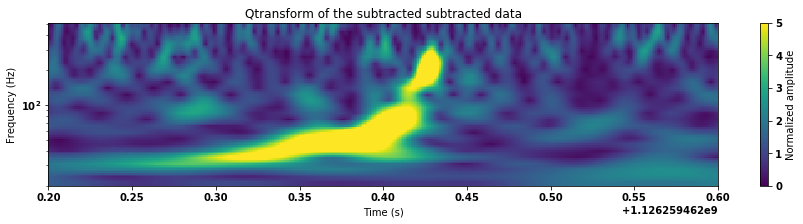

In [25]:
#trial of direct subtraction

dt = tmaxS02 - subF02.start_time
inj = hmaxS02.cyclic_time_shift(dt)

#scale tempplate

inj /= sigma(hmaxS02, psd = psdS2, low_frequency_cutoff = 20.)
inj *= maxsnrS02

subsubF02 = subF02 - inj

#whiten 

subsub_white02 = (subsubF02/psdS2**0.5).to_timeseries()
zoom = subsub_white02.time_slice(merger.time -2, merger.time + 2)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))

plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

Text(0.5,1,'Whitened data of GW150914 with the signal injected at 5 s')

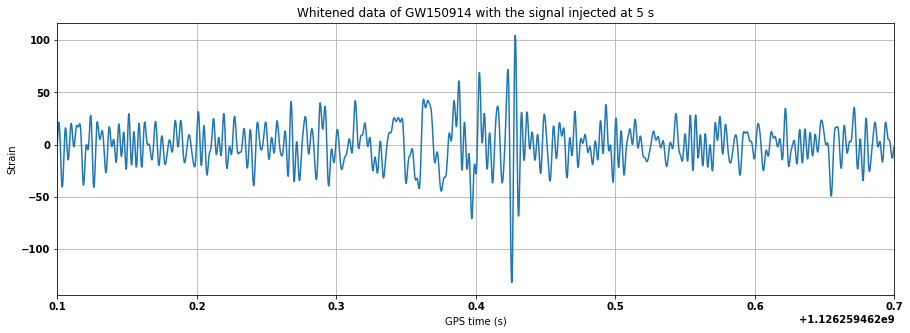

In [26]:
#whitening of the data
white_sigS02 =  (subF02/psdS2**0.5).to_timeseries()
white_sigS02 = white_sigS02.highpass_fir(30., 512).lowpass_fir(300, 512)
white_sigS02 = white_sigS02.time_slice(merger.time - 5, merger.time + 5)

plt.figure(figsize = [15, 5])
plt.plot(white_sigS02.sample_times, white_sigS02)
plt.xlim(merger.time - 0.3, merger.time + .3)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.grid()
plt.title("Whitened data of GW150914 with the signal injected at 0.02 s after first subtraction")

In [27]:
def gen_template(theta, delta_t = sub02.delta_t, 
                 duration = sub02.duration, start_time = sub02.start_time,
                 f_lower = f_low):
    
    #unpack values used to adapt the template
    m1, m2, dist, time = theta
    
    #make the templayte with the values provided and adjust it to data
    hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1,
                            mass2 = m2, distance = dist, 
                             delta_t = delta_t, f_lower = f_low)
    
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - sub02.start_time)
    hp.start_time = sub02.start_time
    
    return hp

In [28]:
from pycbc.filter import get_cutoff_indices as get_ind

def loglikelihood(theta, df = subF02, f_lower = f_low, f_upper = f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t = df.delta_t, 
                            f_lower = f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = get_ind(f_lower, f_upper, df.delta_f,
                                          (N-1)*2)
    
    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj() * hf[kmin:kmax]).real()/psdS2[kmin:kmax])
    dh = sum (4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psdS2[kmin:kmax])
    
    logl = -0.5*(hh - 2.0*dh)
    
    return logl

In [29]:
def whiten_trim_template(template, psd = psdS2):
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd**0.5).to_timeseries()
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 5)
    
    return white_temp

def plot_white_strain(strain, template, zoom):
    white_data = (subF02/psdS2**0.5).to_timeseries()
    
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psdS2 **0.5).to_timeseries()
    
    white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data = white_data.time_slice(merger.time - 5, merger.time + 5)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 5)
    
    plt.figure(figsize = [15 , 3])
    plt.plot(white_data.sample_times, white_data, label = 'data')
    plt.plot(white_temp.sample_times, white_temp, label = 'template')
    plt.legend()
    plt.grid()
    plt.title("Superposition data and template")
    plt.ylabel("Strain")
    plt.xlabel("GPS time (s)")
    
    if zoom is True:
        plt.xlim(merger.time - 0.2, merger.time + 0.2)
    if zoom is False:
        plt.xlim(merger.time - 0.5, merger.time + 0.5)
        

-655.3954916092456


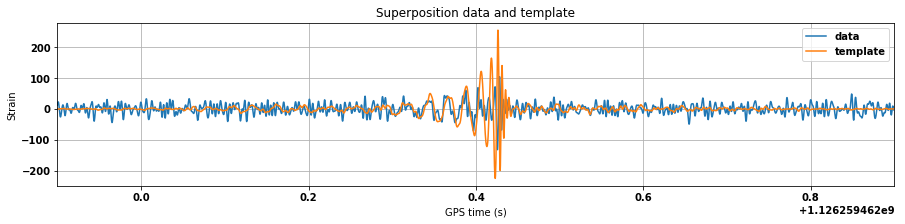

In [30]:
theta0 = [m1maxS02, m2maxS02, 440, tmaxS02]

temp0 = gen_template(theta0)
plot_white_strain(sub02, temp0, False)

print(loglikelihood(theta0))

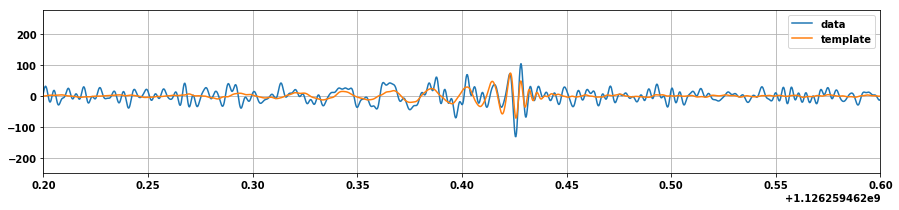

Steps 	 log(likelihood)
5 	 58.236


In [31]:
#best fit to adapt the found parameters to the signal
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize = [15, 3])
Neval = 1

white_temp = whiten_trim_template(gen_template(theta0))

plt.plot(white_sigS02.sample_times, white_sigS02, label = 'data')
line, = plt.plot(white_temp.sample_times, white_temp, label = 'template')

plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.grid()
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    temp = gen_template(thetai)
    white_temp = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_temp)
    
    clear_output(wait = True)
    display(fig)
    print("Steps \t log(likelihood)")
    print("%i \t %.3f" %(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta : -loglikelihood(theta), theta0, 
              callback = callback, method = 'powell')
plt.close()

[4.10073022e+01 2.24916737e+01 1.20518776e+03 1.12625946e+09]


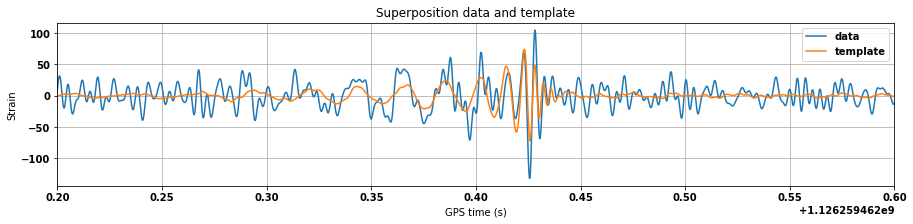

In [32]:
paramS02 = res.x
print(paramS02)
bestSub02 = gen_template(paramS02)
plot_white_strain(sub02, bestSub02, True)

In [2]:
subsub02 = sub02 - bestSub02

t, f, p = subsub02.whiten(2,2).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted best fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 0.2, merger.time + 0.2)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

NameError: name 'sub02' is not defined

In this case, even if we do the sbtraction of the second event after the fitting, we see that it is not weel done anymore. However, it could still be slightly enhanced by the use of other templates. Since their remain a banaa shape after subtraction, we could see if it is possible to find a third "false" event. Another option is to allow a wider range of masses for the superposed signals and se if such a case enables to subtract fully the superposed signal

#### Test if third signal present

In [34]:
subsubF02 = subsub02.to_frequencyseries()

In [35]:
pSub02 = subsub02.psd(2)
pSub02 = interpolate(pSub02, subsub02.delta_f)
psdSub02 = inverse_spectrum_truncation(pSub02, 2*subsub02.sample_rate,
                                      low_frequency_cutoff = 20.)

In [ ]:
mass1 = np.arange(1, 81, 1)
mass2 = np.arange(20, 41, 1)

hmax = None
maxsnrSub02, m1maxSub02, m2maxSub02, tmaxSub02 = 0, 0, 0, 0

snrsSub02 = [[] for i in range(len(mass1))]
max_snrsSub02 = [[] for i in range(len(mass1))]
times_maxSub02 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = subsubF02.delta_f)
        hp.resize(len(subsubF02))
        
        snr = matched_filter(hp, subsubF02, psd = psdSub02, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 5, merger.time + 5)
        snrsSub02[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsSub02[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxSub02[i].append(time)
        
        # Keep track of the max snr
        
        if snrp > maxsnrSub02:
            tmaxSub02, hmaxSub02, m1maxSub02, m2maxSub02, maxsnrSub02 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxSub02, m2maxSub02, tmaxSub02, maxsnrSub02))
print(time_inj)
print(merger.time)

mass 1 1/79
Done
mass 1 2/79
Done
mass 1 3/79
Done
mass 1 4/79
Done
mass 1 5/79
Done
mass 1 6/79
Done
mass 1 7/79
Done
mass 1 8/79
Done
mass 1 9/79
Done
mass 1 10/79
Done
mass 1 11/79
Done
mass 1 12/79
Done
mass 1 13/79
Done
mass 1 14/79
Done
mass 1 15/79
Done
mass 1 16/79
Done
mass 1 17/79
Done
mass 1 18/79
Done
mass 1 19/79
Done
mass 1 20/79
Done
mass 1 21/79
Done
mass 1 22/79
Done
mass 1 23/79
Done
mass 1 24/79
